<a href="https://colab.research.google.com/github/LapTQ/surface_defect_detection/blob/main/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:
* Detection
 * [Steel Surface: NEU-CLS](http://faculty.neu.edu.cn/songkc/en/zdylm/263265/list/index.htm)
 * [DeepPBC](https://github.com/Charmve/Surface-Defect-Detection/tree/master/DeepPCB)
* Segmenation
 * [Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/overview)
 * [AITEX FABRIC IMAGE DATABASE](https://www.aitex.es/afid/)

* EDA
* algorithms to detect ROI then classify (2 stages): faster RCNN, seam carving, interest points,...
* classify then detect ROI: saliency map
* compare to papers with the same dataset

https://towardsdatascience.com/i-performed-error-analysis-on-open-images-and-now-i-have-trust-issues-89080e03ba09

https://stackoverflow.com/questions/67244258/how-to-get-class-and-bounding-box-coordinates-from-yolov5-predictions

https://docs.ultralytics.com/tutorials/pytorch-hub/

https://stackoverflow.com/questions/54165439/what-are-the-exact-color-names-available-in-pils-imagedraw

## Import

In [1]:
!git clone https://github.com/LapTQ/surface_defect_detection.git
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install opencv-python-headless==4.1.2.30

Cloning into 'surface_defect_detection'...
remote: Enumerating objects: 3983, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 3983 (delta 106), reused 0 (delta 0), pack-reused 3821
Receiving objects: 100% (3983/3983), 842.57 MiB | 37.31 MiB/s, done.
Resolving deltas: 100% (1929/1929), done.
Checking out files: 100% (3610/3610), done.
Cloning into 'yolov5'...
remote: Enumerating objects: 11742, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 11742 (delta 14), reused 27 (delta 9), pack-reused 11707
Receiving objects: 100% (11742/11742), 11.36 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (8116/8116), done.
     |████████████████████████████████| 596 kB 25.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/albumentatio

In [2]:
import torch
import numpy as np
import tensorflow as tf
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 CPU


## EDA

In [3]:
print('[INFO] number of xml files:', len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))))
print('[INFO] number of images (.jpg) files:', len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))))

[INFO] number of xml files: 1800
[INFO] number of images (.jpg) files: 1800


In [4]:
# show an example
!cat surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml

<annotation>
	<folder>cr</folder>
	<filename>crazing_2.jpg</filename>
	<source>
		<database>NEU-DET</database>
	</source>
	<size>
		<width>200</width>
		<height>200</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>99</xmin>
			<ymin>120</ymin>
			<xmax>200</xmax>
			<ymax>174</ymax>
		</bndbox>
	</object>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>16</ymin>
			<xmax>200</xmax>
			<ymax>111</ymax>
		</bndbox>
	</object>
</annotation>


In [5]:
def extract_info_from_xml(xml_file):
    """Read xml file and extract information.
    Arguments:
        xml_file - path to the xml file.
    Return a dictionary containing info.
    """
    xml_root = ET.parse(xml_file).getroot()

    info = {}
    info['bboxes'] = []
    
    for element in xml_root:
        # get image file name
        if element.tag == 'filename':
            info['filename'] = element.text

        # get image size
        if element.tag == 'size':
            image_size = []
            for sub_element in element:
                info['image_' + sub_element.tag] = int(sub_element.text)
        
        # get bounding boxes
        if element.tag == 'object':
            bbox = {}
            for sub_element in element:
                if sub_element.tag == 'name':
                    bbox['class'] = sub_element.text
                elif sub_element.tag == 'bndbox':
                    for sub_sub_element in sub_element:
                        bbox[sub_sub_element.tag] = int(sub_sub_element.text)
            info['bboxes'].append(bbox)
    return info

In [6]:
extract_info_from_xml('surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml')

{'bboxes': [{'class': 'crazing',
   'xmax': 200,
   'xmin': 99,
   'ymax': 174,
   'ymin': 120},
  {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}],
 'filename': 'crazing_2.jpg',
 'image_depth': 1,
 'image_height': 200,
 'image_width': 200}

In [7]:
class_name_to_color_mapping = {
    'crazing': 'red',
    'inclusion': 'orange',
    'patches': 'darkgoldenrod',
    'pitted_surface': 'deepskyblue',
    'rolled-in_scale': 'mediumseagreen',
    'scratches': 'deeppink'
}

class_name_to_id_mapping = {
    'crazing': 0, 
    'inclusion': 1, 
    'patches': 2, 
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}
class_id_to_name_mapping = {class_id: class_name for class_name, class_id in class_name_to_id_mapping.items()}
class_id_to_name_mapping

{0: 'crazing',
 1: 'inclusion',
 2: 'patches',
 3: 'pitted_surface',
 4: 'rolled-in_scale',
 5: 'scratches'}

In [8]:
!mkdir dataset
!mkdir dataset/labels
!cp -r surface_defect_detection/NEU-DET/IMAGES /content/dataset/images

In [9]:
def convert_to_yolov5(info):
    """Convert extracted info into yolov5 required format and save it in a new labels directory.
    Argument:
        info - Python dictionary. Eg:
            {
            'bboxes': [
                        {'class': 'crazing', 'xmax': 200, 'xmin': 99, 'ymax': 174, 'ymin': 120},
                        {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}
                      ],
            'filename': 'crazing_2.jpg',
            'image_size': (200, 200, 1)
            }
    => converted as: class_id x y w h
        0 0.747500 0.735000 0.505000 0.270000
        0 0.520000 0.317500 0.960000 0.475000

    """
    buffer = []

    for bbox in info['bboxes']:
        try:
            class_id = class_name_to_id_mapping[bbox['class']]
        except KeyError:
            print('Invalid class. Must be one from', class_name_to_id_mapping)

        # convert to [x, y, w, h]
        bx = (bbox['xmin'] + bbox['xmax']) / 2
        by = (bbox['ymin'] + bbox['ymax']) / 2
        bw = (bbox['xmax'] - bbox['xmin'])
        bh = (bbox['ymax'] - bbox['ymin'])

        # normalize bbox dimensions
        bx /= info['image_width']
        by /= info['image_height']
        bw /= info['image_width']
        bh /= info['image_height']

        buffer.append('{} {:3f} {:3f} {:3f} {:3f}'.format(class_id, bx, by, bw, bh))
    
    # store in .txt file
    save_filename = os.path.join('dataset/labels', info['filename'].replace('.jpg', '') + '.txt')
    print('\n'.join(buffer), file=open(save_filename, 'w'))
    return {'class_id': class_id,
            'bx': bx,
            'by': by,
            'bw': bw,
            'bh': bh}

In [10]:
# Extract info from .xml files and save in .txt files
for ann in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
    info = extract_info_from_xml(ann)
    convert_to_yolov5(info)

In [11]:
# check for any missing
assert len(list(Path('dataset/labels').glob('*.txt'))) == len(list(Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'))), "Missing some .txt files"
assert len(list(Path('dataset/images').glob('*.jpg'))) == len(list(Path('surface_defect_detection/NEU-DET/IMAGES').glob('*.jpg'))), "Missing some images"

In [12]:
# # extract info from annotation folder and store in a Dataframe
# info_list = []
# for xml_path in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
#     info = extract_info_from_xml(xml_path)
#     for bbox in info['bboxes']:
#         info_list.append(
#             {'image_width': info['image_width'],
#              'image_height': info['image_height'],
#              'image_depth': info['image_depth'],
#              'filename': info['filename'],
#              'class': bbox['class'],
#              'xmin': bbox['xmin'],
#              'ymin': bbox['ymin'],
#              'xmax': bbox['xmax'],
#              'ymax': bbox['ymax'],
#             #  'bbox_x': (bbox['xmin'] + bbox['xmax']) / 2,
#             #  'bbox_y': (bbox['ymin'] + bbox['ymax']) / 2,
#             #  'bbox_width': (bbox['xmax'] - bbox['xmin']),
#             #  'bbox_height': (bbox['ymax'] - bbox['ymin'])
#              }
#         )

# info_df = pd.DataFrame.from_dict(info_list)
# info_df

In [13]:
# print("[INFO] number of images:", len(info_df['filename'].unique()))
# print("[INFO] image size: ({}, {}, {})".format(info_df['image_width'].unique()[0], info_df['image_height'].unique()[0], info_df['image_depth'].unique()[0]))
# info_df.groupby('class')['class'].count().plot.bar(ylabel='number of object', rot=15)

# # info_df['x'] = (info_df['xmin'] + info_df['xmax']) / 2
# # info_df['y'] = (info_df['ymin'] + info_df['ymax']) / 2
# info_df['w'] = (info_df['xmax'] - info_df['xmin'])
# info_df['h'] = (info_df['ymax'] - info_df['ymin'])

# colors = {
#     'crazing': (0, 0, 1),
#     'inclusion': (0, 1, 0),
#     'patches': (1, 0, 0),
#     'pitted_surface': (1, 1, 0),
#     'rolled-in_scale': (1, 0, 1),
#     'scratches': (0, 1, 1)
# }
# plt.figure(figsize=(15, 15))
# ax = plt.gca()
# for index in info_df.index:
#     patch = plt.Rectangle([100 - info_df.iloc[index]['w']/2, 100 - info_df.iloc[index]['h']/2], info_df.iloc[index]['w'], info_df.iloc[index]['h'],
#                           fill=False, edgecolor=colors[info_df.iloc[index]['class']], linewidth=1)
#     ax.add_patch(patch)
# plt.ylim([0, 200])
# plt.xlim([0, 200])
# plt.show()


In [14]:
tf.keras.utils.get_file(origin='https://ultralytics.com/assets/Arial.ttf')

def plot_bbox(image, annotations):
    """
    Arguments:
        image - array in range [0, 255]
        annotations - numpy array,
            if shape is (n, 6): each bbox is of format (bx, by, bw, bh, conf, class_id)
            if shape is (n, 5): each bbox is of format (bx, by, bw, bh, class_id)
    """
    image = Image.fromarray(image)  # convert to PIL Image
    # annotations = np.array(annotations)
    image_w, image_h = image.size

    plotted_img = ImageDraw.Draw(image)

    # convert [bx, by, bw, bh] to actual size in pixel [x, y, w, h]
    transformed_ann = np.copy(annotations)
    transformed_ann[:, [0, 2]] = annotations[:, [0, 2]] * image_w
    transformed_ann[:, [1, 3]] = annotations[:, [1, 3]] * image_h
    
    # convert [x, y, w, h] to [xmin, ymin, xmax, ymax]
    transformed_ann[:, 0] -= transformed_ann[:, 2] / 2
    transformed_ann[:, 1] -= transformed_ann[:, 3] / 2
    transformed_ann[:, 2] += transformed_ann[:, 0]
    transformed_ann[:, 3] += transformed_ann[:, 1]

    font = ImageFont.truetype('/root/.keras/datasets/Arial.ttf', 12)

    for ann in transformed_ann:
        (xmin, ymin, xmax, ymax), class_name = ann[:4], class_id_to_name_mapping[int(ann[-1])]
        xmin = max(xmin, 0)
        ymin = max(ymin, 0)
        xmax = min(xmax, image_w)
        ymax = min(ymax, image_h)
        color = class_name_to_color_mapping[class_name]
        plotted_img.rectangle(((xmin, ymin), (xmax, ymax)), outline=color)
        
        msg = ' ' + class_name + (': {:.2f} '.format(ann[-2]) if transformed_ann.shape[-1] == 6 else ' ')
        text_w, text_h = font.getsize(msg)
        plotted_img.rectangle(((xmin, ymin), (xmin + text_w, ymin + text_h)), fill=color, outline=color)
        plotted_img.text((xmin, ymin), msg, fill='white', font=font)
    
        
    
    plt.imshow(image)

786432/773236 [==============================] - 0s 0us/step


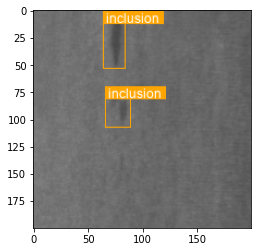

In [15]:
# show an example
annotation_file = random.choice(list(Path('dataset/labels').glob('*.txt')))
with open(annotation_file, 'r') as f:
    annotations = f.read().split('\n')[:-1]
    annotations = [_.split() for _ in annotations]
    annotations = np.array([[float(__) for __ in _] for _ in annotations])

image = plt.imread(str(annotation_file).replace('labels', 'images').replace('txt', 'jpg'))
plot_bbox(image, annotations[:, [1, 2, 3, 4, 0]]) # convert [class_id, bx, by, bw, bh] to [bx, by, bw, bh, class_id]

## Preparing dataset for YOLOv5

In [16]:
annotations = sorted([str(_) for _ in Path('dataset/labels').glob('*.txt')])
images = [_.replace('labels', 'images').replace('txt', 'jpg') for _ in annotations]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=42)

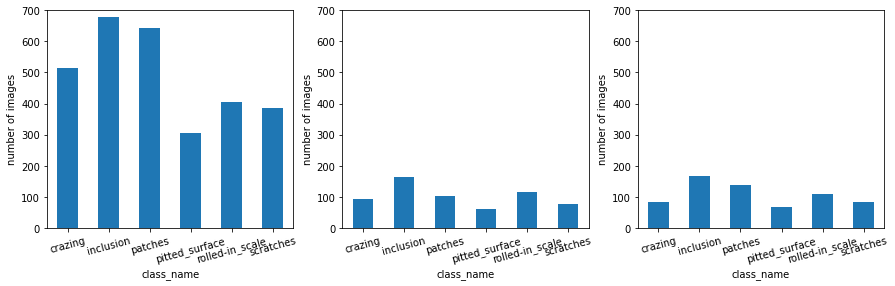

In [17]:
def annotations_to_df(file_list):
    buffer = []
    for txt in file_list:
        with open(txt, 'r') as f:
            annotation_list = f.read().split('\n')[:-1]
            annotation_list = [_.split() for _ in annotation_list]
            for bbox in annotation_list:
                buffer.append(
                    {
                    'filename': txt.split('/')[-1],
                    'class_name': class_id_to_name_mapping[int(bbox[0])],
                    'bx': float(bbox[1]),
                    'by': float(bbox[2]),
                    'bw': float(bbox[3]),
                    'bh': float(bbox[4])
                    }
                )
    return pd.DataFrame.from_dict(buffer)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
annotations_to_df(train_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.subplot(1, 3, 2)
annotations_to_df(val_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.subplot(1, 3, 3)
annotations_to_df(test_annotations).groupby('class_name')['class_name'].count().plot.bar(ylabel='number of images', rot=15)
plt.ylim([0, 700])
plt.show()

In [18]:
!mkdir dataset/images/train dataset/images/val dataset/images/test dataset/labels/train dataset/labels/val dataset/labels/test

In [19]:
def move_files_to_folder(file_list, destination_folder):
    for f in file_list:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

move_files_to_folder(train_images, 'dataset/images/train')
move_files_to_folder(val_images, 'dataset/images/val')
move_files_to_folder(test_images, 'dataset/images/test')
move_files_to_folder(train_annotations, 'dataset/labels/train')
move_files_to_folder(val_annotations, 'dataset/labels/val')
move_files_to_folder(test_annotations, 'dataset/labels/test')

In [20]:
with open('yolov5/data/surface_defect_data.yaml', 'w') as f:
    f.write(f"""train: ../dataset/images/train/
val: ../dataset/images/val/
test: ../dataset/images/test/

# number of classes
nc: 6

# class names
names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']""")

## Training Yolov5

In [ ]:
# train yolov5x model
%cd yolov5
!python train.py --img 640 --batch 16 --epochs 50 --data surface_defect_data.yaml --weights yolov5x.pt --workers 24 --name yolo_surface_defect --cache
# continue training: --weights runs/train/yolo_surface_defect/weights/best.pt
# %cd ..

In [ ]:
# archive weights
!tar -czf ../yolov5_train.tar.gz runs/train/yolo_surface_defect
!tar -czf - runs/train/yolo_surface_defect | split --bytes=99MB - ../yolov5_train.tar.gz

In [ ]:
# get prediction on test images
!python detect.py --source ../dataset/images/test/ --weights runs/train/yolo_surface_defect2/weights/best.pt --conf 0.25 --name yolo_surface_defect

In [ ]:
detection_dir = 'runs/detect/yolo_surface_defect'

random_test_image = Image.open(random.choice(list(Path(detection_dir).glob('*'))))
plt.imshow(random_test_image)

In [ ]:
# evaluate on test images
!python val.py --weights runs/train/yolo_surface_defect/weights/best.pt --data surface_defect_data.yaml --task test --name yolo_surface_defect

In [ ]:
!tar -czf ../yolov5_val.tar.gz runs/val/yolo_surface_defect
!tar -czf ../yolov5_test.tar.gz runs/val/yolo_surface_defect2

## Load Pytorch hub model

In [20]:
!mkdir saved_model
!mkdir saved_model/yolov5

In [21]:
!cat surface_defect_detection/saved_model/yolov5_train.tar.gza* > surface_defect_detection/saved_model/yolov5_train.tar.gz
!tar -xf surface_defect_detection/saved_model/yolov5_train.tar.gz -C saved_model/yolov5

In [ ]:
!tar -xf surface_defect_detection/saved_model/yolov5_test.tar.gz -C saved_model/yolov5
!tar -xf surface_defect_detection/saved_model/yolov5_val.tar.gz -C saved_model/yolov5

In [23]:
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-3-18 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients, 204.1 GFLOPs
Adding AutoShape... 


In [24]:
!python yolov5/val.py --weights saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt --data surface_defect_data.yaml --task test --name yolo_surface_defect

val: data=/content/yolov5/data/surface_defect_data.yaml, weights=['saved_model/yolov5/runs/train/yolo_surface_defect/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_surface_defect, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-38-g7c6a335 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 444 layers, 86207059 parameters, 0 gradients, 204.1 GFLOPs
test: Scanning '/content/yolov5/../dataset/labels/test' images and labels...270 found, 0 missing, 0 empty, 0 corrupt: 100% 270/270 [00:00<00:00, 1733.10it/s]
test: New cache created: /content/yolov5/../dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/9 [00:00<?, ?it/s]tcmalloc: large alloc 1156055040 bytes == 0x55c26764a000 @  0x7f02523beb6b 0x7f02523d

In [25]:
crazing_annotations = list(Path('dataset/labels/test').glob('crazing*.txt'))
crazing_images = [str(_).replace('labels', 'images').replace('txt', 'jpg') for _ in crazing_annotations]
results = yolov5_model(crazing_images, size=200)

In [26]:
results.pandas().xywh[0]

xcenter    ycenter       width      height  confidence  class     name
0  101.297676  54.873119  197.110123  102.285378     0.75567      0  crazing

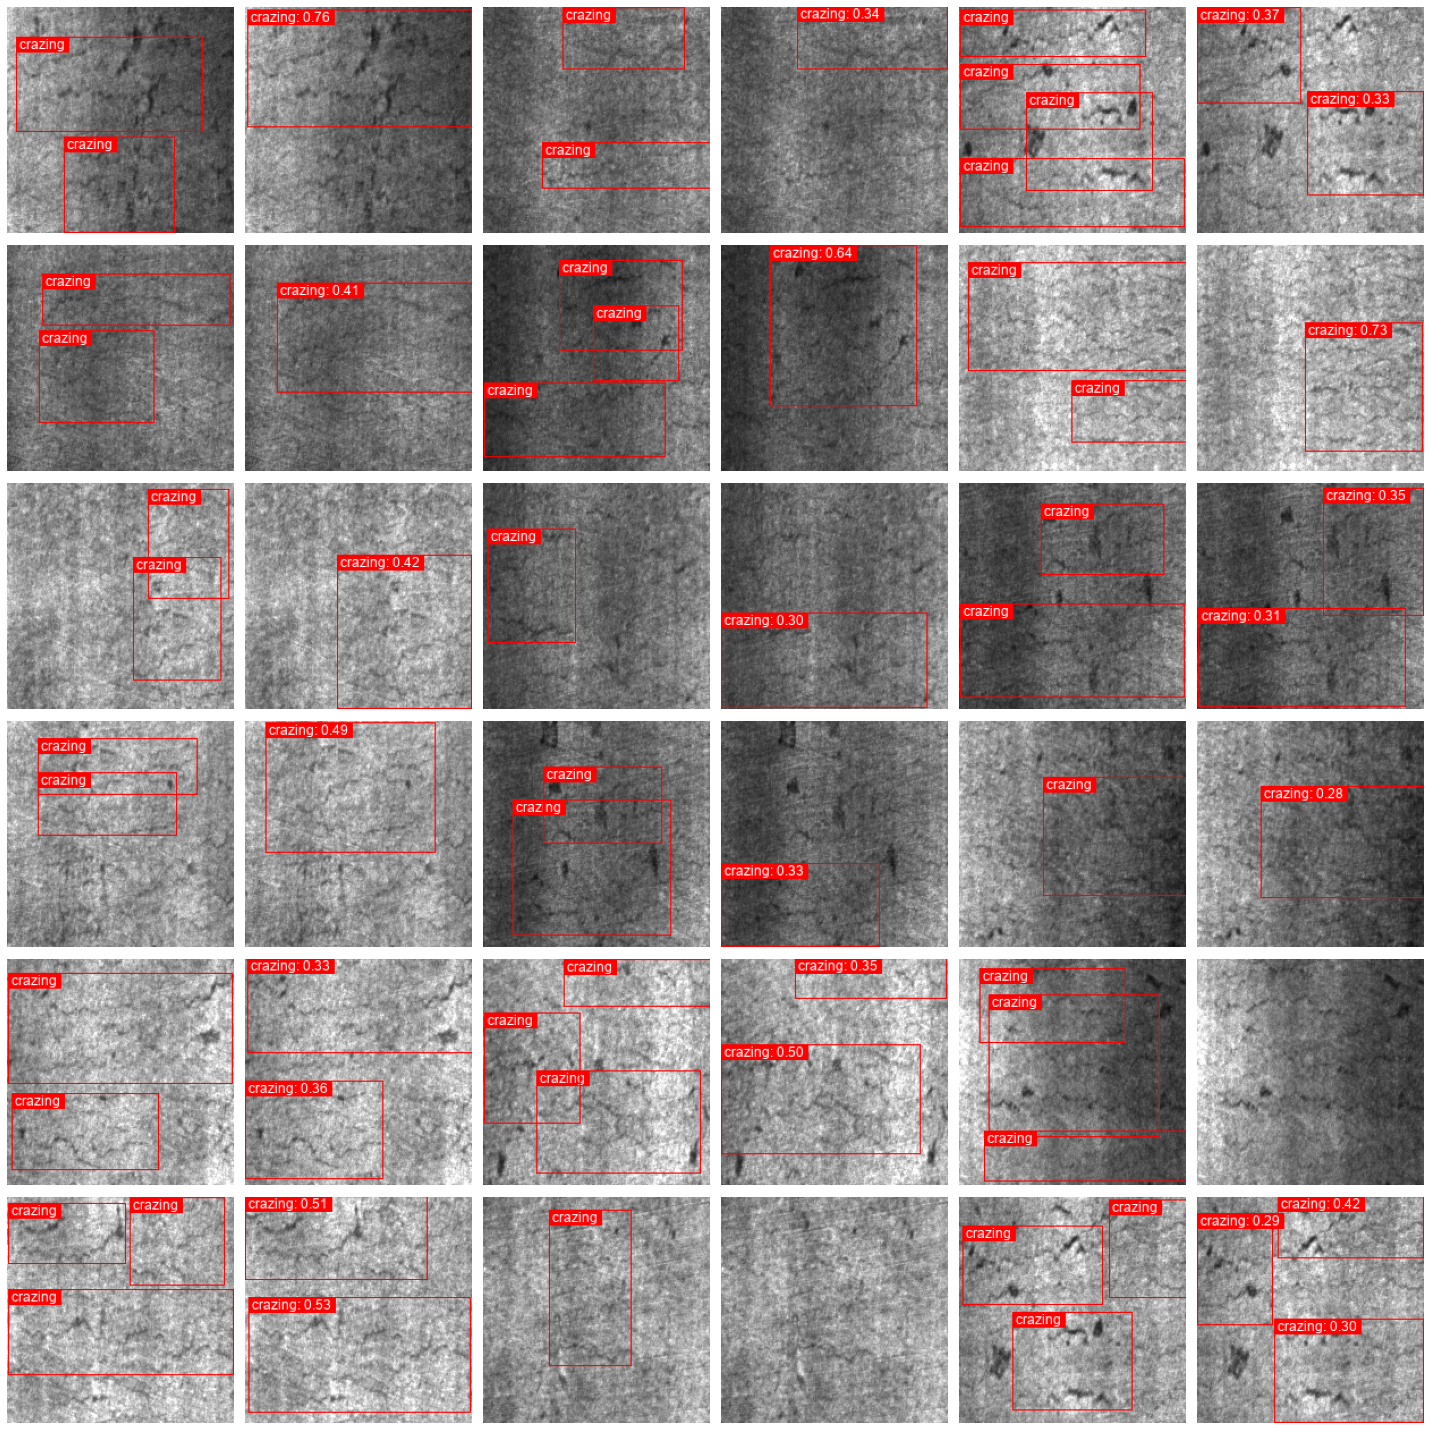

In [27]:
plt.figure(figsize=(20, 20))

for i in range(18):
    annotation_file = crazing_annotations[i]
    with open(annotation_file, 'r') as f:
        annotations = f.read().split('\n')[:-1]
        annotations = [_.split() for _ in annotations]
        annotations = np.array([[float(__) for __ in _] for _ in annotations])

    # image = Image.open(str(annotation_file).replace('labels', 'images').replace('txt', 'jpg'))
    image = crazing_images[i]

    plt.subplot(6, 6, 2*i + 1)
    plot_bbox(image, annotations[:, [1, 2, 3, 4, 0]])
    plt.axis('off')
    plt.subplot(6, 6, 2*i + 2)
    plot_bbox(image, results.xywhn[i].cpu())
    plt.axis('off')
    plt.tight_layout()

## Faster RCNN

The pre-trained models for detection, instance segmentation and keypoint detection are initialized with the classification models in torchvision.

The models expect a list of Tensor[C, H, W], in the range 0-1. The models internally resize the images but the behaviour varies depending on the model.

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [16]:
from torchvision.transforms import functional as F

In [ ]:
# %%shell

# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2
# cd ..

# cp vision/references/detection/utils.py ./
# cp vision/references/detection/transforms.py ./
# cp vision/references/detection/coco_eval.py ./
# cp vision/references/detection/engine.py ./
# cp vision/references/detection/coco_utils.py ./

In [18]:
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

In [17]:
def convert_to_fasterrcnn(info):
    boxes = []
    labels = []
    area = []
    iscrowd = []
    for bbox in info['bboxes']:
        boxes.append([bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']])
        # +1 for background as 0
        labels.append(class_name_to_id_mapping[bbox['class']] + 1)
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    # all objectes are not crowd
    iscrowd = torch.zeros((len(info['bboxes']),), dtype=torch.int64)
    return {
        'boxes': boxes,
        'labels': labels,
        'area': area,
        'iscrowd': iscrowd
    }

In [80]:
target2

{'area': tensor([ 5454., 18240.]), 'boxes': tensor([[ 99., 120., 200., 174.],
         [  8.,  16., 200., 111.]]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1])}

In [122]:
annotation_paths = [
               '/content/surface_defect_detection/NEU-DET/ANNOTATIONS/scratches_2.xml',
               '/content/surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml',
                '/content/surface_defect_detection/NEU-DET/ANNOTATIONS/patches_2.xml',
               '/content/surface_defect_detection/NEU-DET/ANNOTATIONS/inclusion_2.xml'               
]

def create_mosaic(annotation_paths):
    ann_1, ann_2, ann_3, ann_4 = annotation_paths

    info = extract_info_from_xml(ann_1)
    target1 = convert_to_fasterrcnn(info)
    img1 = Image.open(ann_1.replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')).convert('RGB')

    info = extract_info_from_xml(ann_2)
    target2 = convert_to_fasterrcnn(info)
    img2 = Image.open(ann_2.replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')).convert('RGB')

    info = extract_info_from_xml(ann_3)
    target3 = convert_to_fasterrcnn(info)
    img3 = Image.open(ann_3.replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')).convert('RGB')

    info = extract_info_from_xml(ann_4)
    target4 = convert_to_fasterrcnn(info)
    img4 = Image.open(ann_4.replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')).convert('RGB')

    buffer_image = np.empty((200, 200, 3), dtype=np.uint8)
    buffer_boxes = []
    buffer_labels = []


    width_split = np.random.randint(60, 140)
    height_split = np.random.randint(60, 140)

    upper_left = A.Compose(
        [
        A.RandomCrop(width=width_split, height=height_split),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
    )(image=np.array(img1), 
        bboxes=target1['boxes'],
        class_labels=target1['labels']
        )

    buffer_image[:height_split, :width_split,...] = upper_left['image']
    buffer_boxes.extend(upper_left['bboxes'])
    buffer_labels.extend(upper_left['class_labels'])

    upper_right = A.Compose(
        [
        A.RandomCrop(width=200 - width_split, height=height_split),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
    )(image=np.array(img2), 
        bboxes=target2['boxes'],
        class_labels=target2['labels']
        )

    buffer_image[:height_split, width_split:, ...] = upper_right['image']
    for box in upper_right['bboxes']:
        buffer_boxes.append(
            (box[0] + width_split, box[1], box[2] + width_split, box[3])
        )
    buffer_labels.extend(upper_right['class_labels'])

    bottom_left = A.Compose(
        [
        A.RandomCrop(width=width_split, height=200 - height_split),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
    )(image=np.array(img3), 
        bboxes=target3['boxes'],
        class_labels=target3['labels']
        )

    buffer_image[height_split:, :width_split, ...] = bottom_left['image']
    for box in bottom_left['bboxes']:
        buffer_boxes.append(
            (box[0], box[1] + height_split, box[2], box[3] + height_split)
        )
    buffer_labels.extend(bottom_left['class_labels'])

    bottom_right = A.Compose(
        [
        A.RandomCrop(width=200 - width_split, height=200 - height_split),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
    )(image=np.array(img4), 
        bboxes=target4['boxes'],
        class_labels=target4['labels']
        )

    buffer_image[height_split:, width_split:,...] = bottom_right['image']
    for box in bottom_right['bboxes']:
        buffer_boxes.append(
            (box[0] + width_split, box[1] + height_split, box[2] + width_split, box[3] + height_split)
        )
    buffer_labels.extend(bottom_right['class_labels'])

    boxes = torch.as_tensor(buffer_boxes, dtype=torch.float32)
    labels = torch.as_tensor(buffer_labels, dtype=torch.int64)
    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    # all objectes are not crowd
    iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
    return Image.fromarray(np.array(buffer_image)), {
        'boxes': boxes,
        'labels': labels,
        'area': area,
        'iscrowd': iscrowd
    }

img, target = create_mosaic(annotation_paths)
img
target

{'area': tensor([1343.9993,   68.0000, 8170.0000, 1320.0001, 2183.0000, 1825.0000,
          120.0000]),
 'boxes': tensor([[ 80.0000,  16.0000,  94.0000, 112.0000],
         [196.0000,  95.0000, 200.0000, 112.0000],
         [105.0000,   0.0000, 200.0000,  86.0000],
         [  0.0000, 112.0000,  15.0000, 200.0000],
         [ 32.0000, 163.0000,  91.0000, 200.0000],
         [ 30.0000, 112.0000, 103.0000, 137.0000],
         [103.0000, 190.0000, 115.0000, 200.0000]]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([6, 1, 1, 3, 3, 3, 2])}

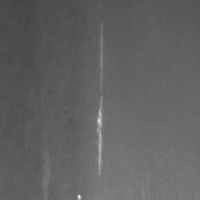

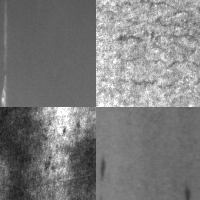

In [91]:
class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transforms=None):
        self.annotation_dir = dataset_dir
        self.transforms = transforms
        
        # load all files, sorting them to
        # ensure that they are aligned
        self.annotations = sorted(list(Path(os.path.join(dataset_dir, 'ANNOTATIONS')).glob('*.xml')))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation_file = self.annotations[idx]
        image_file = str(annotation_file).replace('ANNOTATIONS', 'IMAGES').replace('.xml', '.jpg')
        assert Path(image_file).is_file(), image_file + ' not exists'

        img = Image.open(image_file).convert('RGB')
        

        info = extract_info_from_xml(annotation_file)

        target = convert_to_fasterrcnn(info)
        target['image_id'] = torch.tensor([idx])

        if self.transforms is not None:
            transformed = self.transforms(image=np.array(img), bboxes=target['boxes'], class_labels=target['labels'])
            img = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'])
            target['labels'] = torch.as_tensor(transformed['class_labels'])
        
          
        
        img = F.to_tensor(img)  # also, scale to [0, 1]

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
class mygd(A.GridDropout):
    def apply_to_bbox(self, bbox, **params):
        return bbox

In [ ]:
import albumentations as A

info = extract_info_from_xml('/content/surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml')
target = convert_to_fasterrcnn(info)
img = Image.open('/content/surface_defect_detection/NEU-DET/IMAGES/crazing_2.jpg').convert('RGB')

plt.imshow(img)
plt.show()

transform = A.Compose(
    [
    #  A.RandomCrop(width=150, height=150),
    #  A.GridDropout(ratio=0.5)

    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
)

t = transform(image=np.array(img), 
              bboxes=target['boxes'],
              class_labels=target['labels']
              )
img = t['image']
bboxes = np.array(t['bboxes'])
labels = np.array(t['class_labels'])

print(img)
# print(bboxes)
# print(labels)


plot_bbox(img, np.concatenate([bboxes, np.expand_dims(labels - 1, axis=1)], axis=1))

[(51.999999940395355, 0.0, 65.99999248981476, 99.0), (69.0, 13.999999433755875, 200.0, 99.0), (0.0, 99.0, 40.999998450279236, 200.0), (57.99999850988388, 129.00000008940697, 69.0, 200.0), (55.99999898672104, 99.0, 69.0, 102.99999993667006), (69.0, 165.99999809265137, 85.00000005215406, 200.0), (154.00000900030136, 196.0000011920929, 168.99999910593033, 200.0)]
[tensor(6), tensor(1), tensor(3), tensor(3), tensor(3), tensor(2), tensor(2)]


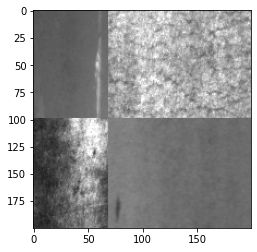

In [79]:


# print(buffer_image)
print(buffer_boxes)
print(buffer_classes)

plt.imshow(buffer_image)

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


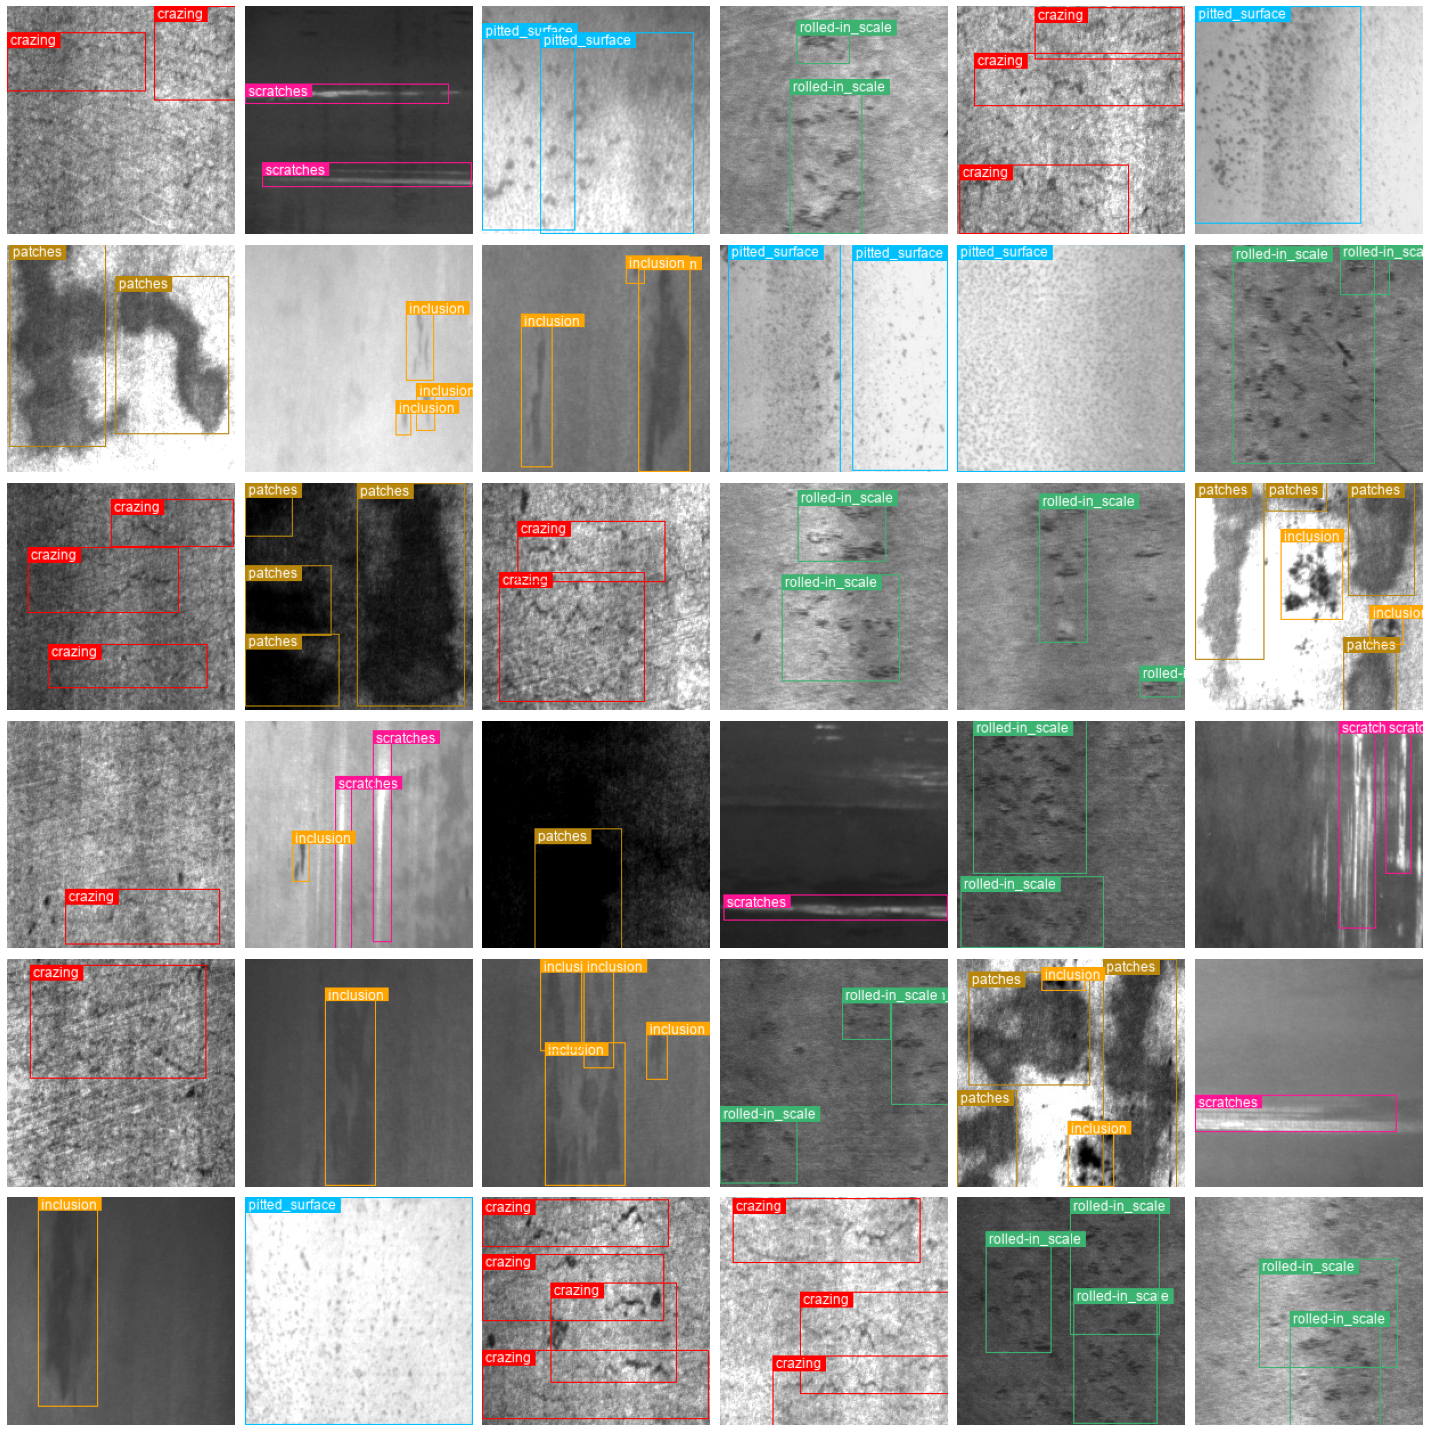

In [95]:
import albumentations as A

transform = A.Compose(
    [
    #  A.Perspective(scale=(0.05, 0.1), fit_output=True, p=0.5),
     A.RandomBrightnessContrast(p=0.5),
    # mygd(ratio=0.4),
    # A.ImageCompression(quality_lower=20, p=0.5),
    # A.CLAHE(p=1)
    ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['class_labels'])
)

def pascal_to_yolo(image, target):
    buffer = np.empty(target['boxes'].shape)
    buffer[:, 0], buffer[:, 1], buffer[:, 2], buffer[:, 3] =\
        (target['boxes'][:, 0] + target['boxes'][:, 2]) / 2 / image.shape[1], \
        (target['boxes'][:, 1] + target['boxes'][:, 3]) / 2 / image.shape[0], \
        (target['boxes'][:, 2] - target['boxes'][:, 0]) / image.shape[1], \
        (target['boxes'][:, 3] - target['boxes'][:, 1]) / image.shape[0]
    return np.array(image), np.concatenate([buffer, np.expand_dims(target['labels'] - 1, axis=1)], axis=1)


dataset = DefectDataset('surface_defect_detection/NEU-DET', transform)

# split to train - test

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn
)

plt.figure(figsize=(20, 20))
i = 1
j = 0
for imgs, targets in data_loader:
    for img, target in zip(imgs, targets):
        print(img.shape)
        plt.subplot(6, 6, i)
        i += 1
        img, bboxes = pascal_to_yolo(img.permute(1, 2, 0).mul(255).byte(), target)
        
        plot_bbox(img, bboxes)
        plt.axis('off')
    j += 1
    if j == 9:
        break
plt.tight_layout()
plt.show()

In [24]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterrcnn_model(num_classes):
    # load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the pre-trained head with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [25]:
from collections import Counter

def average_precisions(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=7):
    # torchvision.ops.box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor)
    """
    pred_boxes - Python list of list [image_id, class_prediction, prob_score, x1, y1, x2, y2].
    output_boxes - similar to pred_boxes, but this is the ground truth.
    iou_threshold - IoU threshold to assign TP, FP, FN
    num_classes - number of classes in the dataset, INCLUDING background class
    """

    average_precisions = {}
    epsilon = 1e-6

    for c in range(1, num_classes):
        detections = [detection for detection in pred_boxes if detection[1] == c]
        ground_truths = [true_box for true_box in true_boxes if true_box[1] == c]


        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            if len(ground_truth_img) == 0:
                continue

            # print(torch.tensor(ground_truth_img)[:, -4:])

            ious = torch.squeeze(torchvision.ops.box_iou(
                torch.tensor([detection[-4:]]),
                torch.tensor(ground_truth_img)[:, -4:]
            ))
            
            best_iou = torch.max(ious)
            best_gt_idx = torch.argmax(ious)

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        average_precisions[c] = torch.trapz(precisions, recalls).item()

    return average_precisions

In [26]:
class Evaluator:
    def __init__(self):
        self.pred_boxes = []
        self.true_boxes = []

    def update(self, targets, outputs):
        for target, output in zip(targets, outputs):
            for class_id, bbox in zip(target['labels'], target['boxes']):
                self.true_boxes.append(
                    [target['image_id'].item(),
                     class_id.item(),
                     *[d.item() for d in bbox]]
                )
            for class_id, score, bbox in zip(output['labels'], output['scores'], output['boxes']):
                self.pred_boxes.append(
                    [target['image_id'].item(),
                     class_id.item(),
                     score.item(),
                     *[d.item() for d in bbox]]
                )

    
    def summary(self):
        AP_5 = average_precisions(self.pred_boxes, self.true_boxes, 0.5, 7)
        AP_5 = {class_id_to_name_mapping[k - 1]: v for k, v in AP_5.items()}
        AP_5['all'] = sum(_ for _ in AP_5.values()) / 6
        
        AP_5_95 = {k: [] for k in AP_5.keys()}

        for iou_thres in np.arange(0.5, 1, 0.05):
            AP_thres = average_precisions(self.pred_boxes, self.true_boxes, iou_thres, 7)
            for c in AP_thres.keys():
                AP_5_95[class_id_to_name_mapping[c - 1]].append(AP_thres[c])
        AP_5_95 = {k: sum(v) / len(np.arange(0.5, 1, 0.05)) for k, v in AP_5_95.items()}
        AP_5_95['all'] = sum(_ for _ in AP_5_95.values()) / 6

        return {
            'AP@0.5': AP_5,
            'AP@0.5:0.95': AP_5_95
        }

In [27]:
class Tracker:
    def __init__(self, kind):
        assert kind == 'train' or kind == 'val', "Invalid value for argument kind: Neither 'train' nor 'val'"

        if kind == 'train':
            self.data = pd.DataFrame(columns=['epoch', 'loss', 'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']).set_index(['epoch'])
        else:
            self.data = pd.DataFrame(columns=['epoch', 'class', 'AP@0.5', 'AP@0.5:0.95']).set_index(['epoch', 'class'])
        self.record_path = None
        self.kind = kind
        if not Path('fasterrcnn').is_dir():
            Path('fasterrcnn/').mkdir(parents=True, exist_ok=True)

    def load_result(self, record_path, overwrite):
        self.record_path = record_path
        if self.kind == 'train':
            self.data = pd.read_csv(record_path, index_col=['epoch'])
        else:
            self.data = pd.read_csv(record_path, index_col=['epoch', 'class'])
        
        if overwrite:
            self.record_path = record_path

    def save_result(self):
        if self.record_path is None:
            if len(list(Path('fasterrcnn').glob(self.kind + '*.csv'))) == 0:
                filename = self.kind + '0.csv'
            else:
                filename = self.kind + str(int(sorted([str(_) for _ in Path('fasterrcnn').glob(self.kind + '*.csv')])[-1][-5]) + 1) + '.csv'
            self.record_path = os.path.join('fasterrcnn', filename)
        self.data.to_csv(self.record_path)

    def update_loss(self, loss_dict, epoch):
        self.data.loc[epoch] = loss_dict

    def update_map(self, map_dict, epoch):
        for class_name in map_dict['AP@0.5']:
            self.data = self.data.reset_index().append({
                'epoch': epoch,
                'class': class_name,
                'AP@0.5': map_dict['AP@0.5'][class_name],
                'AP@0.5:0.95': map_dict['AP@0.5:0.95'][class_name]
            }, ignore_index=True).set_index(['epoch', 'class'], drop=True)
            

In [28]:
import time

def train_one_epoch(model, optimizer, data_loader, device, epoch, tracker, print_freq=10):
    model.train()
    epoch_loss = 0
    epoch_loss_dict = {'loss_classifier': 0,
                       'loss_box_reg': 0,
                       'loss_objectness': 0,
                       'loss_rpn_box_reg': 0,
                       'loss': 0}

    start_time = time.time()

    for i, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  # returns losses and detections
        loss_dict['loss'] = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()

        for k in epoch_loss_dict.keys():
            epoch_loss_dict[k] += loss_dict[k]

        if i % print_freq == 0:    
            print(f"Epoch: [{epoch}]  [{i}/{len(data_loader)}]  Elapsed time: {time.time() - start_time}  lr: {optimizer.param_groups[0]['lr']}  loss: {loss_dict['loss']}  loss_classifier: {loss_dict['loss_classifier'].item()}  loss_box_reg: {loss_dict['loss_box_reg'].item()}  loss_objectness: {loss_dict['loss_objectness'].item()}  loss_rpn_box_reg: {loss_dict['loss_rpn_box_reg'].item()}")
    
    with torch.no_grad():
        for k in epoch_loss_dict.keys():
                epoch_loss_dict[k] = (epoch_loss_dict[k] / len(data_loader)).cpu().item()
    
    tracker.update_loss(epoch_loss_dict, epoch)

    return epoch_loss_dict['loss']


def evaluate_one_epoch(model, data_loader, device, epoch, tracker, print_freq=10):
    
    evaluator = Evaluator()
    
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [image.to(device) for image in images]

            FPS = time.time()
            outputs = model(images)
            FPS = len(images) / (time.time() - FPS)
            outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

            evaluator.update(targets, outputs)
            
            if i % print_freq == 0:
                print(f"Test: [{epoch}] [{i}/{len(data_loader)}] Elapsed time: {time.time() - start_time} FPS: {FPS}")            

    tracker.update_map(evaluator.summary(), epoch)
    print(evaluator.summary())


In [29]:
dataset = DefectDataset('surface_defect_detection/NEU-DET', get_transform(train=True))
dataset_test = DefectDataset('surface_defect_detection/NEU-DET', get_transform(train=False))

# split to train - test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:1260])
dataset_test = torch.utils.data.Subset(dataset_test, indices[1260:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn
)

## Train with default anchor boxes

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# +1 for background (needed for faster rcnn)
num_classes = 7
fasterrcnn_model = get_fasterrcnn_model(num_classes)
fasterrcnn_model.to(device)

params = [p for p in fasterrcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


Epoch: [2]  [0/158]  Elapsed time: 1.0641090869903564  lr: 0.0005  loss: 0.30323395133018494  loss_classifier: 0.10897558182477951  loss_box_reg: 0.1623619794845581  loss_objectness: 0.010830582119524479  loss_rpn_box_reg: 0.021065814420580864
Epoch: [2]  [10/158]  Elapsed time: 17.30498194694519  lr: 0.0005  loss: 0.32480326294898987  loss_classifier: 0.10489705950021744  loss_box_reg: 0.1995536834001541  loss_objectness: 0.005098617635667324  loss_rpn_box_reg: 0.01525389775633812
Epoch: [2]  [20/158]  Elapsed time: 34.25932002067566  lr: 0.0005  loss: 0.3008933663368225  loss_classifier: 0.10763012617826462  loss_box_reg: 0.16946205496788025  loss_objectness: 0.007589540909975767  loss_rpn_box_reg: 0.016211621463298798
Epoch: [2]  [30/158]  Elapsed time: 51.61176133155823  lr: 0.0005  loss: 0.2790798842906952  loss_classifier: 0.09407408535480499  loss_box_reg: 0.15399771928787231  loss_objectness: 0.007928109727799892  loss_rpn_box_reg: 0.023079972714185715
Epoch: [2]  [40/158]  Ela

<Figure size 504x360 with 0 Axes>

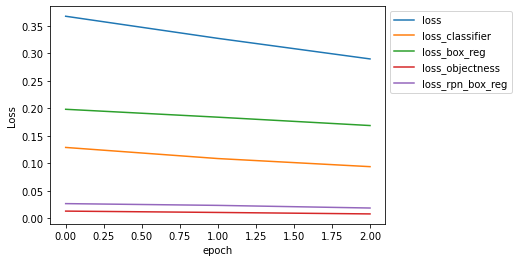

Test: [2] [0/68] Elapsed time: 0.9133656024932861 FPS: 11.044773977407122
Test: [2] [10/68] Elapsed time: 8.854692935943604 FPS: 10.31715511661765
Test: [2] [20/68] Elapsed time: 16.732237100601196 FPS: 11.06877302940837
Test: [2] [30/68] Elapsed time: 24.609055042266846 FPS: 10.683719302692037
Test: [2] [40/68] Elapsed time: 32.50581431388855 FPS: 10.657576790323754
Test: [2] [50/68] Elapsed time: 40.361469745635986 FPS: 10.897657394326172
Test: [2] [60/68] Elapsed time: 48.2975914478302 FPS: 10.494772385786295
{'AP@0.5': {'crazing': 0.42827948927879333, 'inclusion': 0.8311522006988525, 'patches': 0.9123960733413696, 'pitted_surface': 0.829261064529419, 'rolled-in_scale': 0.6075959205627441, 'scratches': 0.9484447836875916, 'all': 0.7595215886831284}, 'AP@0.5:0.95': {'crazing': 0.12659119714517147, 'inclusion': 0.4268798751523718, 'patches': 0.5650036462116986, 'pitted_surface': 0.43961744707194156, 'rolled-in_scale': 0.2520843331469223, 'scratches': 0.5224918950116262, 'all': 0.38877

<Figure size 504x360 with 0 Axes>

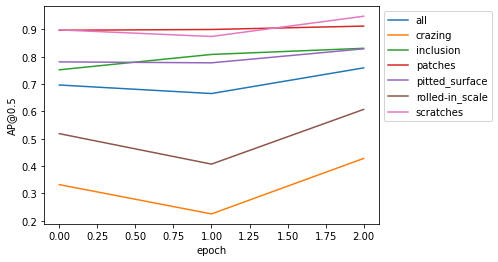

<Figure size 504x360 with 0 Axes>

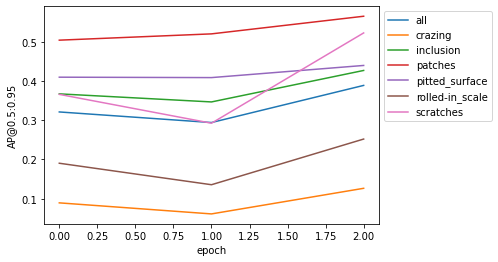

Epoch: [3]  [0/158]  Elapsed time: 1.0319921970367432  lr: 0.0005  loss: 0.2955760657787323  loss_classifier: 0.09831089526414871  loss_box_reg: 0.1714492291212082  loss_objectness: 0.007704004179686308  loss_rpn_box_reg: 0.018111946061253548
Epoch: [3]  [10/158]  Elapsed time: 17.515447854995728  lr: 0.0005  loss: 0.1917845904827118  loss_classifier: 0.06887464225292206  loss_box_reg: 0.10177864134311676  loss_objectness: 0.0038177412934601307  loss_rpn_box_reg: 0.01731356792151928
Epoch: [3]  [20/158]  Elapsed time: 34.75330185890198  lr: 0.0005  loss: 0.28702548146247864  loss_classifier: 0.08863437920808792  loss_box_reg: 0.16111084818840027  loss_objectness: 0.013752542436122894  loss_rpn_box_reg: 0.023527707904577255
Epoch: [3]  [30/158]  Elapsed time: 51.90536904335022  lr: 0.0005  loss: 0.22084951400756836  loss_classifier: 0.08025599271059036  loss_box_reg: 0.1196649968624115  loss_objectness: 0.010241683572530746  loss_rpn_box_reg: 0.010686845518648624
Epoch: [3]  [40/158]  E

<Figure size 504x360 with 0 Axes>

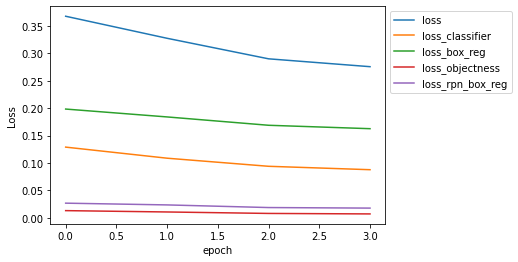

Test: [3] [0/68] Elapsed time: 0.9211790561676025 FPS: 11.119071012483857
Test: [3] [10/68] Elapsed time: 8.896497964859009 FPS: 10.359500352114742
Test: [3] [20/68] Elapsed time: 16.840434551239014 FPS: 10.944291617877774
Test: [3] [30/68] Elapsed time: 24.77087140083313 FPS: 10.407692548673186
Test: [3] [40/68] Elapsed time: 32.662113189697266 FPS: 10.634082184417851
Test: [3] [50/68] Elapsed time: 40.58051943778992 FPS: 10.656510601430547
Test: [3] [60/68] Elapsed time: 48.52002930641174 FPS: 10.330651721065527
{'AP@0.5': {'crazing': 0.4576019048690796, 'inclusion': 0.8451095223426819, 'patches': 0.9090860486030579, 'pitted_surface': 0.8504098057746887, 'rolled-in_scale': 0.6220656633377075, 'scratches': 0.9458828568458557, 'all': 0.7716926336288452}, 'AP@0.5:0.95': {'crazing': 0.13931619679897267, 'inclusion': 0.4416726180221303, 'patches': 0.5688848928082735, 'pitted_surface': 0.44715428091585635, 'rolled-in_scale': 0.2441453659790568, 'scratches': 0.5371871986601036, 'all': 0.396

<Figure size 504x360 with 0 Axes>

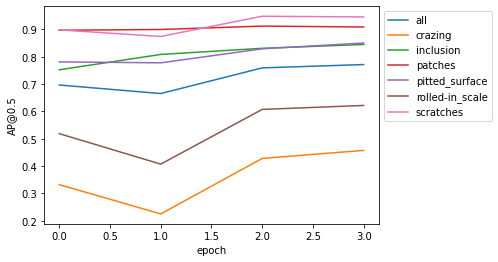

<Figure size 504x360 with 0 Axes>

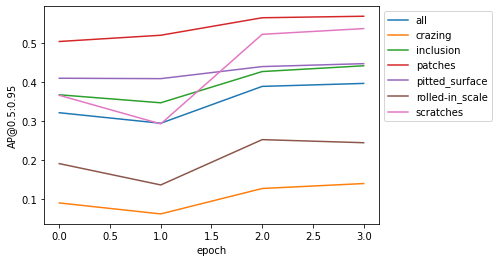

Epoch: [4]  [0/158]  Elapsed time: 1.0586628913879395  lr: 0.0005  loss: 0.22230584919452667  loss_classifier: 0.07173968851566315  loss_box_reg: 0.1333836168050766  loss_objectness: 0.007309680804610252  loss_rpn_box_reg: 0.009872864931821823
Epoch: [4]  [10/158]  Elapsed time: 17.513444900512695  lr: 0.0005  loss: 0.24249984323978424  loss_classifier: 0.0782293826341629  loss_box_reg: 0.15089012682437897  loss_objectness: 0.005403176881372929  loss_rpn_box_reg: 0.007977161556482315
Epoch: [4]  [20/158]  Elapsed time: 34.666412591934204  lr: 0.0005  loss: 0.2757452130317688  loss_classifier: 0.0774008184671402  loss_box_reg: 0.18686604499816895  loss_objectness: 0.003689488861709833  loss_rpn_box_reg: 0.007788865827023983
Epoch: [4]  [30/158]  Elapsed time: 51.85101819038391  lr: 0.0005  loss: 0.34522658586502075  loss_classifier: 0.10227500647306442  loss_box_reg: 0.21594005823135376  loss_objectness: 0.011425439268350601  loss_rpn_box_reg: 0.015586071647703648
Epoch: [4]  [40/158]  

<Figure size 504x360 with 0 Axes>

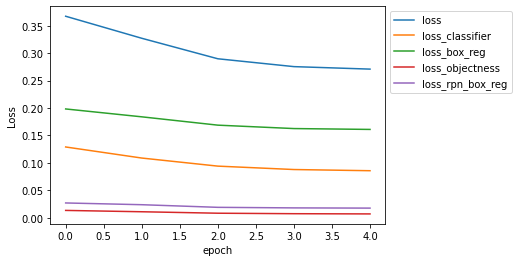

Test: [4] [0/68] Elapsed time: 0.9426283836364746 FPS: 10.641714323409568
Test: [4] [10/68] Elapsed time: 8.914075374603271 FPS: 10.31195521729844
Test: [4] [20/68] Elapsed time: 16.818663835525513 FPS: 10.82849192101118
Test: [4] [30/68] Elapsed time: 24.714630365371704 FPS: 10.847384687002961
Test: [4] [40/68] Elapsed time: 32.62777137756348 FPS: 10.568900919640662
Test: [4] [50/68] Elapsed time: 40.50731086730957 FPS: 11.211535229475325
Test: [4] [60/68] Elapsed time: 48.41367769241333 FPS: 10.267489222090271
{'AP@0.5': {'crazing': 0.43108826875686646, 'inclusion': 0.8383952975273132, 'patches': 0.9070746898651123, 'pitted_surface': 0.8222764730453491, 'rolled-in_scale': 0.6333330273628235, 'scratches': 0.9516456127166748, 'all': 0.7639688948790232}, 'AP@0.5:0.95': {'crazing': 0.13315591214695816, 'inclusion': 0.4371958193834871, 'patches': 0.5719880510354415, 'pitted_surface': 0.44548164382576944, 'rolled-in_scale': 0.26441099679796026, 'scratches': 0.547572511708131, 'all': 0.3999

<Figure size 504x360 with 0 Axes>

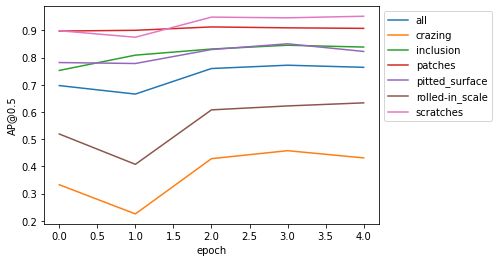

<Figure size 504x360 with 0 Axes>

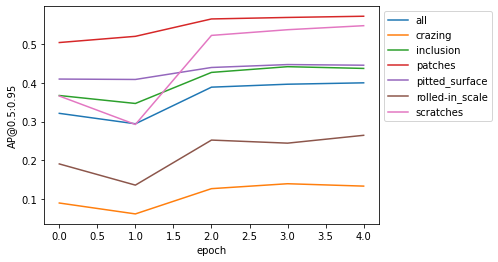

Epoch: [5]  [0/158]  Elapsed time: 1.0673441886901855  lr: 5e-05  loss: 0.27694985270500183  loss_classifier: 0.08851409703493118  loss_box_reg: 0.14933902025222778  loss_objectness: 0.0056025306694209576  loss_rpn_box_reg: 0.033494219183921814
Epoch: [5]  [10/158]  Elapsed time: 17.559988260269165  lr: 5e-05  loss: 0.3920723497867584  loss_classifier: 0.11100523918867111  loss_box_reg: 0.2468341886997223  loss_objectness: 0.01579172909259796  loss_rpn_box_reg: 0.01844117045402527
Epoch: [5]  [20/158]  Elapsed time: 34.80978274345398  lr: 5e-05  loss: 0.24598635733127594  loss_classifier: 0.0701579675078392  loss_box_reg: 0.15499597787857056  loss_objectness: 0.003706306917592883  loss_rpn_box_reg: 0.017126094549894333
Epoch: [5]  [30/158]  Elapsed time: 51.929964780807495  lr: 5e-05  loss: 0.3156587481498718  loss_classifier: 0.10515743494033813  loss_box_reg: 0.18859532475471497  loss_objectness: 0.006279619410634041  loss_rpn_box_reg: 0.015626370906829834
Epoch: [5]  [40/158]  Elaps

<Figure size 504x360 with 0 Axes>

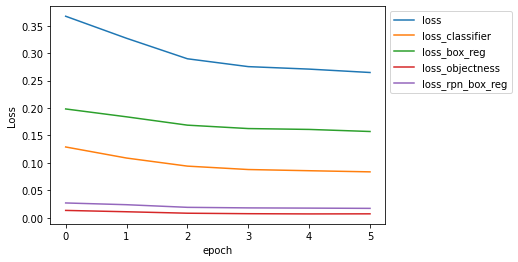

Test: [5] [0/68] Elapsed time: 0.906949520111084 FPS: 11.116135183502985
Test: [5] [10/68] Elapsed time: 8.913604974746704 FPS: 10.30215309587167
Test: [5] [20/68] Elapsed time: 16.877980709075928 FPS: 10.232324507556283
Test: [5] [30/68] Elapsed time: 24.870417833328247 FPS: 10.388150342345734
Test: [5] [40/68] Elapsed time: 32.77392554283142 FPS: 9.831821005379684
Test: [5] [50/68] Elapsed time: 40.779733419418335 FPS: 10.18508360075132
Test: [5] [60/68] Elapsed time: 48.71205806732178 FPS: 10.194159260041287
{'AP@0.5': {'crazing': 0.4521239995956421, 'inclusion': 0.8333402872085571, 'patches': 0.9078371524810791, 'pitted_surface': 0.8380856513977051, 'rolled-in_scale': 0.6177577376365662, 'scratches': 0.9599636793136597, 'all': 0.7681847512722015}, 'AP@0.5:0.95': {'crazing': 0.14324876306254736, 'inclusion': 0.4353479908313602, 'patches': 0.5681252363137901, 'pitted_surface': 0.44163356963545086, 'rolled-in_scale': 0.26160554625093935, 'scratches': 0.5497326076030731, 'all': 0.39994

<Figure size 504x360 with 0 Axes>

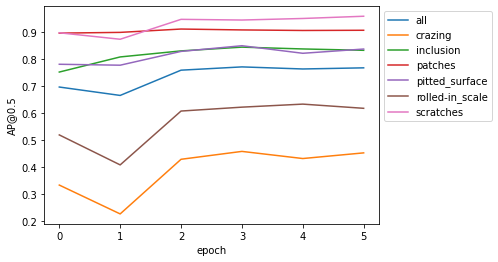

<Figure size 504x360 with 0 Axes>

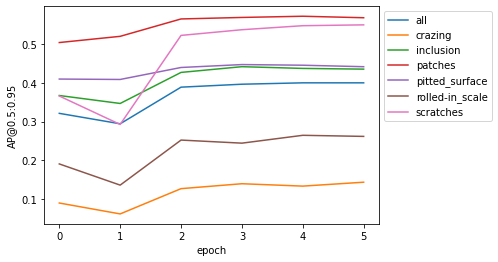

In [ ]:
train_tracker = Tracker(kind='train')
test_tracker = Tracker(kind='val')

for epoch in range(24):

    if len(list(Path('fasterrcnn').glob('train*'))) != 0:
        train_tracker.load_result('fasterrcnn/train0.csv', overwrite=True)
    loss = train_one_epoch(fasterrcnn_model, optimizer, data_loader, device, epoch, train_tracker, print_freq=10)
    train_tracker.save_result()
    
    plt.figure(figsize=(7, 5))
    train_tracker.data.plot.line(ylabel='Loss').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    lr_scheduler.step(loss)

    if len(list(Path('fasterrcnn').glob('val*'))) != 0:
        test_tracker.load_result('fasterrcnn/val0.csv', overwrite=True)    
    evaluate_one_epoch(fasterrcnn_model, data_loader_test, device, epoch, test_tracker, print_freq=10)
    test_tracker.save_result()

    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5', ylabel='AP@0.5').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5:0.95', ylabel='AP@0.5:0.95').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 7

backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios= ((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

fasterrcnn_model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

fasterrcnn_model.to(device)

params = [p for p in fasterrcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


Epoch: [0]  [0/315]  Elapsed time: 1.5460705757141113  lr: 0.005  loss: 2.834028959274292  loss_classifier: 1.929192304611206  loss_box_reg: 0.052669912576675415  loss_objectness: 0.7237546443939209  loss_rpn_box_reg: 0.12841196358203888
Epoch: [0]  [10/315]  Elapsed time: 14.745588541030884  lr: 0.005  loss: 1.1789239645004272  loss_classifier: 0.6041476130485535  loss_box_reg: 0.11174444854259491  loss_objectness: 0.34216535091400146  loss_rpn_box_reg: 0.12086649239063263
Epoch: [0]  [20/315]  Elapsed time: 27.659503698349  lr: 0.005  loss: 0.7668423652648926  loss_classifier: 0.37466785311698914  loss_box_reg: 0.16200309991836548  loss_objectness: 0.1749284267425537  loss_rpn_box_reg: 0.05524300038814545
Epoch: [0]  [30/315]  Elapsed time: 40.53058910369873  lr: 0.005  loss: 0.611702561378479  loss_classifier: 0.2463008314371109  loss_box_reg: 0.12872257828712463  loss_objectness: 0.1881512701511383  loss_rpn_box_reg: 0.048527806997299194
Epoch: [0]  [40/315]  Elapsed time: 53.48750

<Figure size 504x360 with 0 Axes>

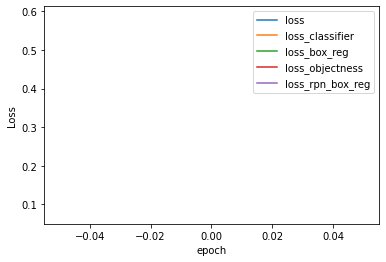

Test: [0] [0/135] Elapsed time: 0.43855762481689453 FPS: 14.410593114063568
Test: [0] [10/135] Elapsed time: 3.3953094482421875 FPS: 14.255927005699068
Test: [0] [20/135] Elapsed time: 6.539878606796265 FPS: 13.124292340102306
Test: [0] [30/135] Elapsed time: 9.634944438934326 FPS: 13.585120286322745
Test: [0] [40/135] Elapsed time: 12.695436477661133 FPS: 13.127496340044491
Test: [0] [50/135] Elapsed time: 15.796691656112671 FPS: 13.867209765193644
Test: [0] [60/135] Elapsed time: 18.883646488189697 FPS: 13.62344335669787
Test: [0] [70/135] Elapsed time: 22.035103797912598 FPS: 12.891221680516656
Test: [0] [80/135] Elapsed time: 25.158766984939575 FPS: 12.293504464645547
Test: [0] [90/135] Elapsed time: 28.358903884887695 FPS: 12.753043983258662
Test: [0] [100/135] Elapsed time: 31.442962884902954 FPS: 13.195652105519812
Test: [0] [110/135] Elapsed time: 34.555251359939575 FPS: 14.698212618030112
Test: [0] [120/135] Elapsed time: 37.703678131103516 FPS: 13.851215897692045
Test: [0] [1

<Figure size 504x360 with 0 Axes>

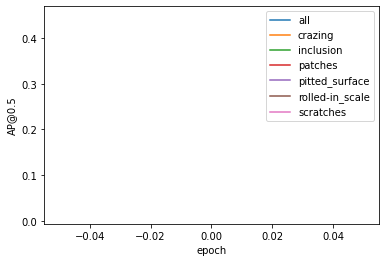

<Figure size 504x360 with 0 Axes>

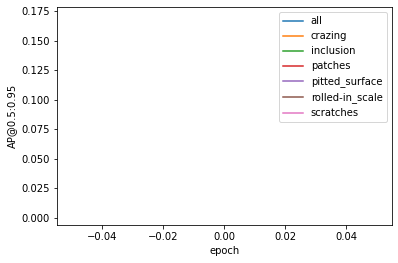

Epoch: [1]  [0/315]  Elapsed time: 1.1491763591766357  lr: 0.005  loss: 0.502128541469574  loss_classifier: 0.21859322488307953  loss_box_reg: 0.17243428528308868  loss_objectness: 0.09025062620639801  loss_rpn_box_reg: 0.0208504069596529
Epoch: [1]  [10/315]  Elapsed time: 13.182721138000488  lr: 0.005  loss: 0.44845467805862427  loss_classifier: 0.16163954138755798  loss_box_reg: 0.15925537049770355  loss_objectness: 0.09099678695201874  loss_rpn_box_reg: 0.03656298667192459
Epoch: [1]  [20/315]  Elapsed time: 25.203895807266235  lr: 0.005  loss: 0.7518396377563477  loss_classifier: 0.2540825605392456  loss_box_reg: 0.27744054794311523  loss_objectness: 0.1505231261253357  loss_rpn_box_reg: 0.06979343295097351
Epoch: [1]  [30/315]  Elapsed time: 37.55023407936096  lr: 0.005  loss: 0.526629626750946  loss_classifier: 0.18919458985328674  loss_box_reg: 0.14449059963226318  loss_objectness: 0.09753238409757614  loss_rpn_box_reg: 0.09541204571723938
Epoch: [1]  [40/315]  Elapsed time: 50

<Figure size 504x360 with 0 Axes>

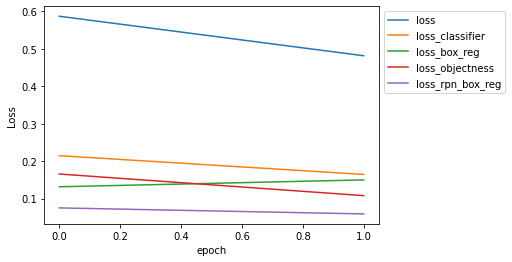

Test: [1] [0/135] Elapsed time: 0.4798123836517334 FPS: 12.08817619098741
Test: [1] [10/135] Elapsed time: 3.810237407684326 FPS: 12.706585193690186
Test: [1] [20/135] Elapsed time: 7.397090435028076 FPS: 11.831897120168692
Test: [1] [30/135] Elapsed time: 10.835206270217896 FPS: 13.312334758417997
Test: [1] [40/135] Elapsed time: 14.229352235794067 FPS: 11.85538272812326
Test: [1] [50/135] Elapsed time: 17.658652782440186 FPS: 13.154319182383773
Test: [1] [60/135] Elapsed time: 21.030028343200684 FPS: 12.828765672539975
Test: [1] [70/135] Elapsed time: 24.585676908493042 FPS: 10.141083583527616
Test: [1] [80/135] Elapsed time: 28.03464412689209 FPS: 11.116577116326654
Test: [1] [90/135] Elapsed time: 31.493597984313965 FPS: 11.323722545709062
Test: [1] [100/135] Elapsed time: 35.011791467666626 FPS: 11.582475664480498
Test: [1] [110/135] Elapsed time: 38.486467361450195 FPS: 13.94242766477108
Test: [1] [120/135] Elapsed time: 42.02324342727661 FPS: 11.723415643783811
Test: [1] [130/13

<Figure size 504x360 with 0 Axes>

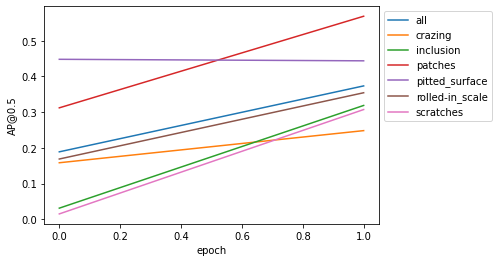

<Figure size 504x360 with 0 Axes>

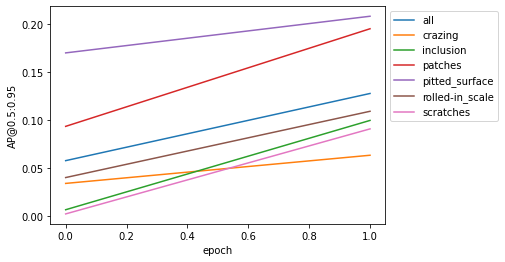

Epoch: [2]  [0/315]  Elapsed time: 1.1711046695709229  lr: 0.005  loss: 0.6653292775154114  loss_classifier: 0.21700340509414673  loss_box_reg: 0.2637123465538025  loss_objectness: 0.14447742700576782  loss_rpn_box_reg: 0.04013607278466225
Epoch: [2]  [10/315]  Elapsed time: 13.787275552749634  lr: 0.005  loss: 0.3764818012714386  loss_classifier: 0.12758396565914154  loss_box_reg: 0.1286277174949646  loss_objectness: 0.08321783691644669  loss_rpn_box_reg: 0.03705226629972458
Epoch: [2]  [20/315]  Elapsed time: 26.373064517974854  lr: 0.005  loss: 0.3484242856502533  loss_classifier: 0.1074790507555008  loss_box_reg: 0.10782795399427414  loss_objectness: 0.08260773867368698  loss_rpn_box_reg: 0.050509534776210785
Epoch: [2]  [30/315]  Elapsed time: 38.985151052474976  lr: 0.005  loss: 0.3425136208534241  loss_classifier: 0.1298534870147705  loss_box_reg: 0.1496720016002655  loss_objectness: 0.04484393075108528  loss_rpn_box_reg: 0.01814420521259308
Epoch: [2]  [40/315]  Elapsed time: 5

<Figure size 504x360 with 0 Axes>

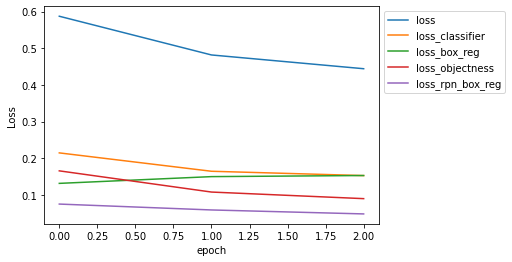

Test: [2] [0/135] Elapsed time: 0.48322272300720215 FPS: 12.456494154945002
Test: [2] [10/135] Elapsed time: 3.9280457496643066 FPS: 12.271016505719988
Test: [2] [20/135] Elapsed time: 7.528802871704102 FPS: 11.829227552995343
Test: [2] [30/135] Elapsed time: 11.006796836853027 FPS: 12.20229496488167
Test: [2] [40/135] Elapsed time: 14.466090679168701 FPS: 11.774542555401467
Test: [2] [50/135] Elapsed time: 17.98277258872986 FPS: 12.249084634193174
Test: [2] [60/135] Elapsed time: 21.45175576210022 FPS: 12.392574449037237
Test: [2] [70/135] Elapsed time: 24.975639581680298 FPS: 10.738655333094373
Test: [2] [80/135] Elapsed time: 28.46746015548706 FPS: 11.384749639841564
Test: [2] [90/135] Elapsed time: 31.972179412841797 FPS: 12.045432745464623
Test: [2] [100/135] Elapsed time: 35.58487892150879 FPS: 10.55176790308876
Test: [2] [110/135] Elapsed time: 39.04024600982666 FPS: 13.308828755648069
Test: [2] [120/135] Elapsed time: 42.59269309043884 FPS: 11.061256432317679
Test: [2] [130/135

<Figure size 504x360 with 0 Axes>

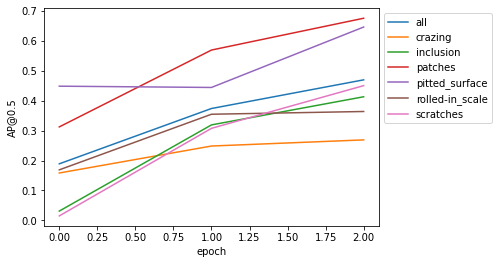

<Figure size 504x360 with 0 Axes>

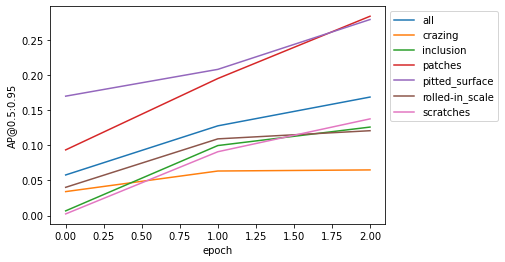

Epoch: [3]  [0/315]  Elapsed time: 1.2181596755981445  lr: 0.005  loss: 0.5290470123291016  loss_classifier: 0.17775604128837585  loss_box_reg: 0.2408793568611145  loss_objectness: 0.08048760890960693  loss_rpn_box_reg: 0.029924020171165466
Epoch: [3]  [10/315]  Elapsed time: 14.142162799835205  lr: 0.005  loss: 0.4183885157108307  loss_classifier: 0.15997318923473358  loss_box_reg: 0.17538772523403168  loss_objectness: 0.053263820707798004  loss_rpn_box_reg: 0.029763799160718918
Epoch: [3]  [20/315]  Elapsed time: 26.73965311050415  lr: 0.005  loss: 0.307122141122818  loss_classifier: 0.07787472754716873  loss_box_reg: 0.0927719920873642  loss_objectness: 0.08087453246116638  loss_rpn_box_reg: 0.05560087412595749
Epoch: [3]  [30/315]  Elapsed time: 39.47891354560852  lr: 0.005  loss: 0.40698444843292236  loss_classifier: 0.11364806443452835  loss_box_reg: 0.08823972195386887  loss_objectness: 0.12745769321918488  loss_rpn_box_reg: 0.07763898372650146
Epoch: [3]  [40/315]  Elapsed time

<Figure size 504x360 with 0 Axes>

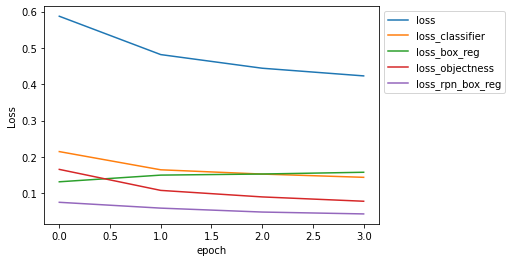

Test: [3] [0/135] Elapsed time: 0.46389126777648926 FPS: 13.237830497668792
Test: [3] [10/135] Elapsed time: 3.6207971572875977 FPS: 14.42932029032
Test: [3] [20/135] Elapsed time: 6.9303297996521 FPS: 13.603217962470618
Test: [3] [30/135] Elapsed time: 10.239885330200195 FPS: 13.663407427676981
Test: [3] [40/135] Elapsed time: 13.460611581802368 FPS: 12.926023601997317
Test: [3] [50/135] Elapsed time: 16.735668659210205 FPS: 13.218774720374158
Test: [3] [60/135] Elapsed time: 19.926653385162354 FPS: 12.88345069611359
Test: [3] [70/135] Elapsed time: 23.2169930934906 FPS: 11.483126995165062
Test: [3] [80/135] Elapsed time: 26.507410049438477 FPS: 11.433224138600758
Test: [3] [90/135] Elapsed time: 29.73926329612732 FPS: 12.843782057367186
Test: [3] [100/135] Elapsed time: 33.081464529037476 FPS: 10.693283210607866
Test: [3] [110/135] Elapsed time: 36.2803156375885 FPS: 13.737189664447445
Test: [3] [120/135] Elapsed time: 39.58080840110779 FPS: 13.295286759881193
Test: [3] [130/135] Ela

<Figure size 504x360 with 0 Axes>

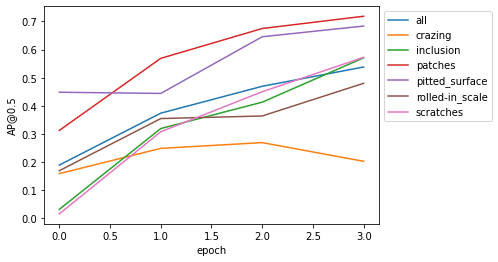

<Figure size 504x360 with 0 Axes>

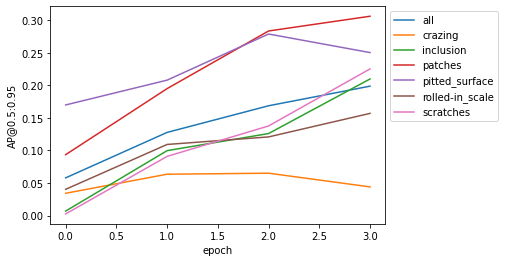

Epoch: [4]  [0/315]  Elapsed time: 1.173414707183838  lr: 0.005  loss: 0.3626580238342285  loss_classifier: 0.13708436489105225  loss_box_reg: 0.12920436263084412  loss_objectness: 0.07041431963443756  loss_rpn_box_reg: 0.025954952463507652
Epoch: [4]  [10/315]  Elapsed time: 13.668630599975586  lr: 0.005  loss: 0.3792145848274231  loss_classifier: 0.11389370262622833  loss_box_reg: 0.12754157185554504  loss_objectness: 0.07340449094772339  loss_rpn_box_reg: 0.06437480449676514
Epoch: [4]  [20/315]  Elapsed time: 26.38247561454773  lr: 0.005  loss: 0.3955172598361969  loss_classifier: 0.14476600289344788  loss_box_reg: 0.15740028023719788  loss_objectness: 0.06747977435588837  loss_rpn_box_reg: 0.025871194899082184
Epoch: [4]  [30/315]  Elapsed time: 38.98081660270691  lr: 0.005  loss: 0.5063431859016418  loss_classifier: 0.18979525566101074  loss_box_reg: 0.20561429858207703  loss_objectness: 0.08887426555156708  loss_rpn_box_reg: 0.022059407085180283
Epoch: [4]  [40/315]  Elapsed tim

<Figure size 504x360 with 0 Axes>

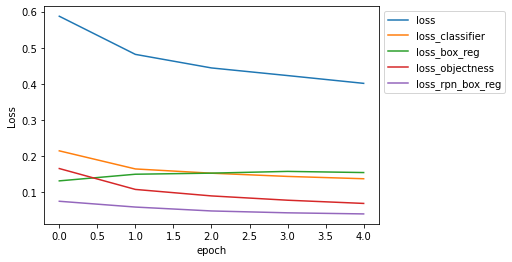

Test: [4] [0/135] Elapsed time: 0.4547708034515381 FPS: 13.12625357745853
Test: [4] [10/135] Elapsed time: 3.854706048965454 FPS: 11.91539940967083
Test: [4] [20/135] Elapsed time: 7.333414554595947 FPS: 12.224032734950942
Test: [4] [30/135] Elapsed time: 10.728275299072266 FPS: 13.00623906922514
Test: [4] [40/135] Elapsed time: 14.113555192947388 FPS: 12.562836587133761
Test: [4] [50/135] Elapsed time: 17.458240509033203 FPS: 13.04877614368791
Test: [4] [60/135] Elapsed time: 20.793700456619263 FPS: 13.108664483610278
Test: [4] [70/135] Elapsed time: 24.202885389328003 FPS: 11.226836457807059
Test: [4] [80/135] Elapsed time: 27.657171726226807 FPS: 11.808412954810192
Test: [4] [90/135] Elapsed time: 31.024984121322632 FPS: 12.481543147328967
Test: [4] [100/135] Elapsed time: 34.52816867828369 FPS: 11.2868513272324
Test: [4] [110/135] Elapsed time: 37.98843240737915 FPS: 14.072425463741554
Test: [4] [120/135] Elapsed time: 41.48354887962341 FPS: 11.639495935906934
Test: [4] [130/135] E

<Figure size 504x360 with 0 Axes>

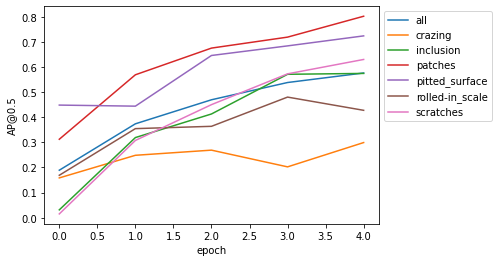

<Figure size 504x360 with 0 Axes>

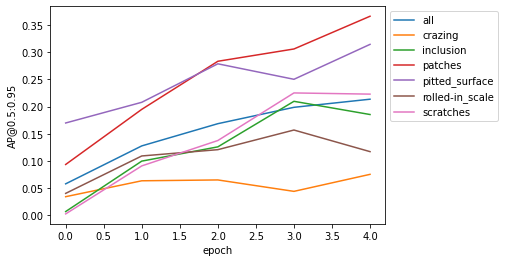

Epoch: [5]  [0/315]  Elapsed time: 1.2006521224975586  lr: 0.005  loss: 0.3014988303184509  loss_classifier: 0.09591839462518692  loss_box_reg: 0.08517400920391083  loss_objectness: 0.06245415657758713  loss_rpn_box_reg: 0.05795224756002426
Epoch: [5]  [10/315]  Elapsed time: 13.80877685546875  lr: 0.005  loss: 0.28456076979637146  loss_classifier: 0.09608881175518036  loss_box_reg: 0.13181379437446594  loss_objectness: 0.03673563897609711  loss_rpn_box_reg: 0.019922522827982903
Epoch: [5]  [20/315]  Elapsed time: 26.51398229598999  lr: 0.005  loss: 0.3353854715824127  loss_classifier: 0.11252906918525696  loss_box_reg: 0.14474020898342133  loss_objectness: 0.0545993372797966  loss_rpn_box_reg: 0.023516861721873283
Epoch: [5]  [30/315]  Elapsed time: 39.24635195732117  lr: 0.005  loss: 0.31404393911361694  loss_classifier: 0.11109057068824768  loss_box_reg: 0.1265754997730255  loss_objectness: 0.04669392481446266  loss_rpn_box_reg: 0.029683955013751984
Epoch: [5]  [40/315]  Elapsed tim

<Figure size 504x360 with 0 Axes>

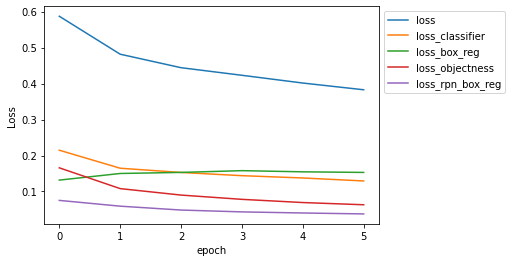

Test: [5] [0/135] Elapsed time: 0.4689021110534668 FPS: 12.646406445159535
Test: [5] [10/135] Elapsed time: 3.867429256439209 FPS: 12.34881853425084
Test: [5] [20/135] Elapsed time: 7.475195407867432 FPS: 12.111598238256912
Test: [5] [30/135] Elapsed time: 10.975225925445557 FPS: 13.130568308286152
Test: [5] [40/135] Elapsed time: 14.466075658798218 FPS: 11.441925999783127
Test: [5] [50/135] Elapsed time: 17.96892237663269 FPS: 11.701477713634484
Test: [5] [60/135] Elapsed time: 21.418985605239868 FPS: 12.966984351245632
Test: [5] [70/135] Elapsed time: 25.013922214508057 FPS: 10.65935424599239
Test: [5] [80/135] Elapsed time: 28.54215908050537 FPS: 10.764154677955293
Test: [5] [90/135] Elapsed time: 31.995861291885376 FPS: 12.180590152413325
Test: [5] [100/135] Elapsed time: 35.589275598526 FPS: 10.479033770198754
Test: [5] [110/135] Elapsed time: 39.11412072181702 FPS: 13.295413193013598
Test: [5] [120/135] Elapsed time: 42.701714515686035 FPS: 11.095103060058408
Test: [5] [130/135] 

<Figure size 504x360 with 0 Axes>

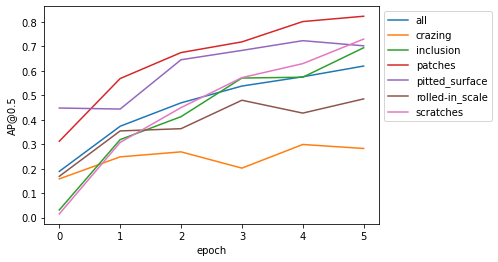

<Figure size 504x360 with 0 Axes>

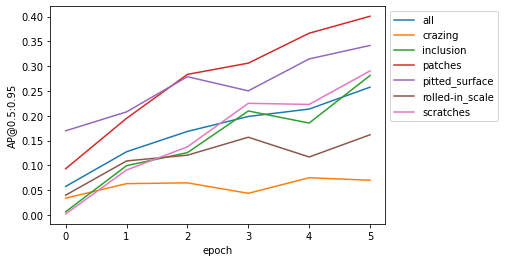

Epoch: [6]  [0/315]  Elapsed time: 1.2154757976531982  lr: 0.005  loss: 0.3887459337711334  loss_classifier: 0.1384514719247818  loss_box_reg: 0.17958755791187286  loss_objectness: 0.044748760759830475  loss_rpn_box_reg: 0.025958161801099777
Epoch: [6]  [10/315]  Elapsed time: 13.874958515167236  lr: 0.005  loss: 0.36687561869621277  loss_classifier: 0.12176020443439484  loss_box_reg: 0.1420280933380127  loss_objectness: 0.04940330982208252  loss_rpn_box_reg: 0.053684018552303314
Epoch: [6]  [20/315]  Elapsed time: 26.407724142074585  lr: 0.005  loss: 0.3369489908218384  loss_classifier: 0.13472656905651093  loss_box_reg: 0.13963541388511658  loss_objectness: 0.05085595324635506  loss_rpn_box_reg: 0.011731065809726715
Epoch: [6]  [30/315]  Elapsed time: 38.94528770446777  lr: 0.005  loss: 0.4666920006275177  loss_classifier: 0.19708792865276337  loss_box_reg: 0.19010759890079498  loss_objectness: 0.055501777678728104  loss_rpn_box_reg: 0.0239946898072958
Epoch: [6]  [40/315]  Elapsed t

<Figure size 504x360 with 0 Axes>

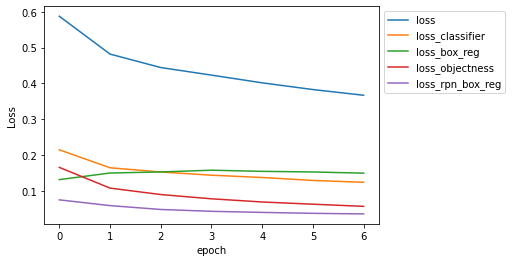

Test: [6] [0/135] Elapsed time: 0.4996819496154785 FPS: 12.103769167781895
Test: [6] [10/135] Elapsed time: 4.128127574920654 FPS: 12.144431237938608
Test: [6] [20/135] Elapsed time: 7.929157733917236 FPS: 11.241264295960983
Test: [6] [30/135] Elapsed time: 11.511119842529297 FPS: 11.514043218455173
Test: [6] [40/135] Elapsed time: 15.122766256332397 FPS: 10.883285611050638
Test: [6] [50/135] Elapsed time: 18.73445200920105 FPS: 11.63838167739823
Test: [6] [60/135] Elapsed time: 22.343963623046875 FPS: 11.504836879189453
Test: [6] [70/135] Elapsed time: 26.07370662689209 FPS: 10.384048247416555
Test: [6] [80/135] Elapsed time: 29.750767469406128 FPS: 10.480696513496916
Test: [6] [90/135] Elapsed time: 33.37650656700134 FPS: 11.466104793531443
Test: [6] [100/135] Elapsed time: 37.0849552154541 FPS: 11.010702104521897
Test: [6] [110/135] Elapsed time: 40.77684712409973 FPS: 13.373926241478486
Test: [6] [120/135] Elapsed time: 44.4529287815094 FPS: 10.628507498522342
Test: [6] [130/135] E

<Figure size 504x360 with 0 Axes>

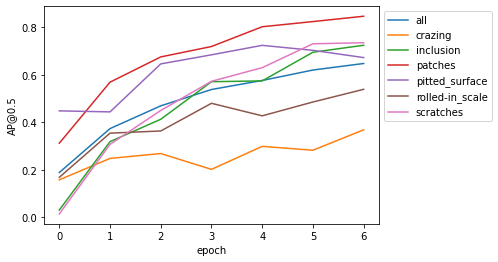

<Figure size 504x360 with 0 Axes>

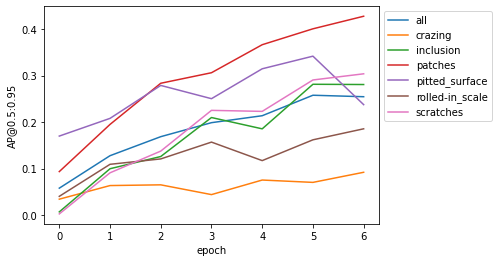

Epoch: [7]  [0/315]  Elapsed time: 1.2039968967437744  lr: 0.005  loss: 0.3263785243034363  loss_classifier: 0.10440950840711594  loss_box_reg: 0.14586897194385529  loss_objectness: 0.0542592778801918  loss_rpn_box_reg: 0.021840790286660194
Epoch: [7]  [10/315]  Elapsed time: 13.87375283241272  lr: 0.005  loss: 0.5095354318618774  loss_classifier: 0.14967228472232819  loss_box_reg: 0.1875515580177307  loss_objectness: 0.0642155185341835  loss_rpn_box_reg: 0.10809606313705444
Epoch: [7]  [20/315]  Elapsed time: 26.412652254104614  lr: 0.005  loss: 0.29872727394104004  loss_classifier: 0.08349926769733429  loss_box_reg: 0.11464186012744904  loss_objectness: 0.046962689608335495  loss_rpn_box_reg: 0.05362346023321152
Epoch: [7]  [30/315]  Elapsed time: 39.143686056137085  lr: 0.005  loss: 0.4055175185203552  loss_classifier: 0.15374179184436798  loss_box_reg: 0.1709558367729187  loss_objectness: 0.05799037963151932  loss_rpn_box_reg: 0.022829532623291016
Epoch: [7]  [40/315]  Elapsed time

<Figure size 504x360 with 0 Axes>

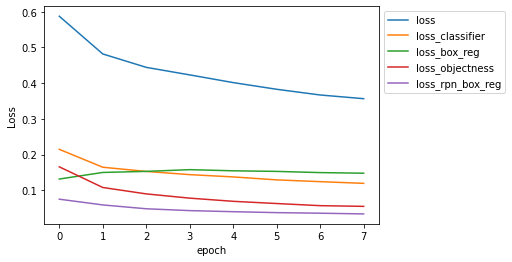

Test: [7] [0/135] Elapsed time: 0.474109411239624 FPS: 13.210187863035335
Test: [7] [10/135] Elapsed time: 3.6431729793548584 FPS: 13.716771167435331
Test: [7] [20/135] Elapsed time: 6.976089000701904 FPS: 12.751890488840244
Test: [7] [30/135] Elapsed time: 10.228386878967285 FPS: 13.190340364107515
Test: [7] [40/135] Elapsed time: 13.449718713760376 FPS: 12.818268222839556
Test: [7] [50/135] Elapsed time: 16.68822693824768 FPS: 14.873418439716312
Test: [7] [60/135] Elapsed time: 19.893498182296753 FPS: 13.490780842163836
Test: [7] [70/135] Elapsed time: 23.227205753326416 FPS: 10.902720933708515
Test: [7] [80/135] Elapsed time: 26.494892120361328 FPS: 12.244748773132402
Test: [7] [90/135] Elapsed time: 29.760590076446533 FPS: 12.274751299927495
Test: [7] [100/135] Elapsed time: 33.05555748939514 FPS: 11.373774557159312
Test: [7] [110/135] Elapsed time: 36.35475516319275 FPS: 13.916510308055496
Test: [7] [120/135] Elapsed time: 39.64838099479675 FPS: 12.299831380771543
Test: [7] [130/1

<Figure size 504x360 with 0 Axes>

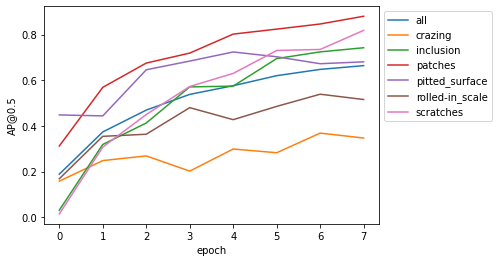

<Figure size 504x360 with 0 Axes>

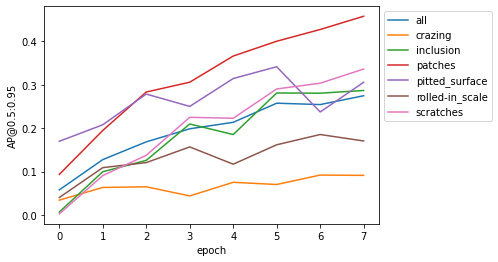

Epoch: [8]  [0/315]  Elapsed time: 1.221313714981079  lr: 0.005  loss: 0.23025278747081757  loss_classifier: 0.08832921832799911  loss_box_reg: 0.10958420485258102  loss_objectness: 0.02580919861793518  loss_rpn_box_reg: 0.006530167534947395
Epoch: [8]  [10/315]  Elapsed time: 13.880654573440552  lr: 0.005  loss: 0.4214678704738617  loss_classifier: 0.1540575474500656  loss_box_reg: 0.17729876935482025  loss_objectness: 0.06650571525096893  loss_rpn_box_reg: 0.023605860769748688
Epoch: [8]  [20/315]  Elapsed time: 26.468319416046143  lr: 0.005  loss: 0.3694136142730713  loss_classifier: 0.14529745280742645  loss_box_reg: 0.16565334796905518  loss_objectness: 0.04236152768135071  loss_rpn_box_reg: 0.016101285815238953
Epoch: [8]  [30/315]  Elapsed time: 39.16549777984619  lr: 0.005  loss: 0.2117418795824051  loss_classifier: 0.08162471652030945  loss_box_reg: 0.08395373076200485  loss_objectness: 0.025458306074142456  loss_rpn_box_reg: 0.020705124363303185
Epoch: [8]  [40/315]  Elapsed 

<Figure size 504x360 with 0 Axes>

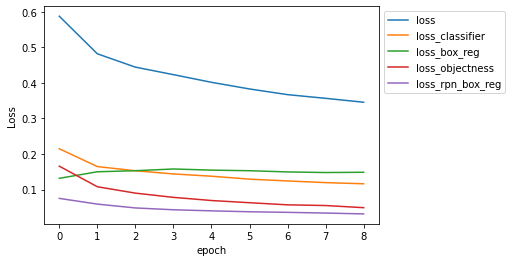

Test: [8] [0/135] Elapsed time: 0.4934971332550049 FPS: 12.288138001549822
Test: [8] [10/135] Elapsed time: 4.385450124740601 FPS: 11.71326639326522
Test: [8] [20/135] Elapsed time: 8.162900447845459 FPS: 11.193339991740373
Test: [8] [30/135] Elapsed time: 11.763261556625366 FPS: 11.512565738189084
Test: [8] [40/135] Elapsed time: 15.363564252853394 FPS: 11.163198713956447
Test: [8] [50/135] Elapsed time: 18.968032836914062 FPS: 12.225199603307328
Test: [8] [60/135] Elapsed time: 22.54980969429016 FPS: 12.159861305292882
Test: [8] [70/135] Elapsed time: 26.33055305480957 FPS: 9.47842284057506
Test: [8] [80/135] Elapsed time: 30.066927909851074 FPS: 10.397730216554098
Test: [8] [90/135] Elapsed time: 33.75611662864685 FPS: 11.033511797228538
Test: [8] [100/135] Elapsed time: 37.49543857574463 FPS: 10.074518168367248
Test: [8] [110/135] Elapsed time: 41.215447425842285 FPS: 12.762298872958302
Test: [8] [120/135] Elapsed time: 44.920220136642456 FPS: 10.46264409570106
Test: [8] [130/135] 

<Figure size 504x360 with 0 Axes>

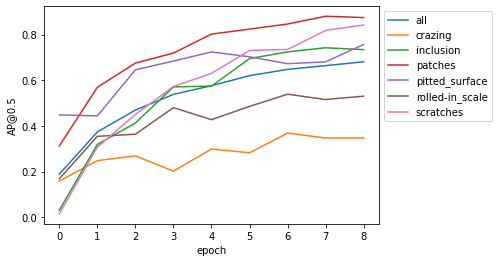

<Figure size 504x360 with 0 Axes>

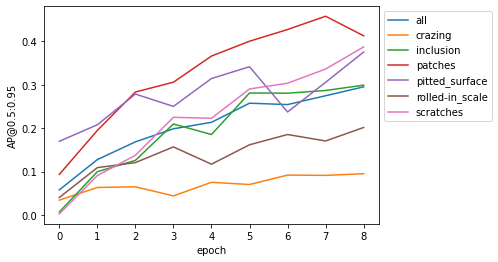

Epoch: [9]  [0/315]  Elapsed time: 1.2082347869873047  lr: 0.005  loss: 0.32940685749053955  loss_classifier: 0.12001101672649384  loss_box_reg: 0.11848947405815125  loss_objectness: 0.046248916536569595  loss_rpn_box_reg: 0.04465743899345398
Epoch: [9]  [10/315]  Elapsed time: 13.87788987159729  lr: 0.005  loss: 0.4125220775604248  loss_classifier: 0.12653189897537231  loss_box_reg: 0.17440636456012726  loss_objectness: 0.07165788859128952  loss_rpn_box_reg: 0.03992592170834541
Epoch: [9]  [20/315]  Elapsed time: 26.64039897918701  lr: 0.005  loss: 0.17159676551818848  loss_classifier: 0.05037834867835045  loss_box_reg: 0.06196003407239914  loss_objectness: 0.026135889813303947  loss_rpn_box_reg: 0.03312248736619949
Epoch: [9]  [30/315]  Elapsed time: 39.209341049194336  lr: 0.005  loss: 0.4336613416671753  loss_classifier: 0.1495695859193802  loss_box_reg: 0.17271898686885834  loss_objectness: 0.06679505109786987  loss_rpn_box_reg: 0.044577717781066895
Epoch: [9]  [40/315]  Elapsed t

<Figure size 504x360 with 0 Axes>

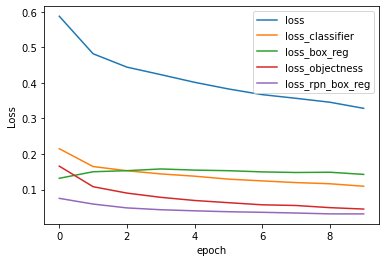

Test: [9] [0/135] Elapsed time: 0.4825756549835205 FPS: 12.079368427873556
Test: [9] [10/135] Elapsed time: 3.985206127166748 FPS: 12.24760920285348
Test: [9] [20/135] Elapsed time: 7.648203611373901 FPS: 11.460394964240093
Test: [9] [30/135] Elapsed time: 11.159674882888794 FPS: 11.880273985601098
Test: [9] [40/135] Elapsed time: 14.68975830078125 FPS: 11.233609466187787
Test: [9] [50/135] Elapsed time: 18.241487741470337 FPS: 12.300958651509097
Test: [9] [60/135] Elapsed time: 21.747510194778442 FPS: 13.041574390119719
Test: [9] [70/135] Elapsed time: 25.338808298110962 FPS: 10.186697656852905
Test: [9] [80/135] Elapsed time: 28.942667961120605 FPS: 11.08284113962139
Test: [9] [90/135] Elapsed time: 32.44261312484741 FPS: 11.840890740834844
Test: [9] [100/135] Elapsed time: 36.08471465110779 FPS: 10.937641836446645
Test: [9] [110/135] Elapsed time: 39.67288684844971 FPS: 12.73038073038073
Test: [9] [120/135] Elapsed time: 43.24738955497742 FPS: 11.252369895519365
Test: [9] [130/135] 

<Figure size 504x360 with 0 Axes>

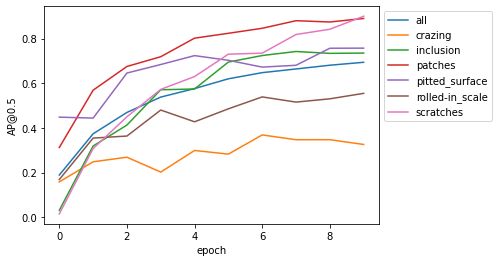

<Figure size 504x360 with 0 Axes>

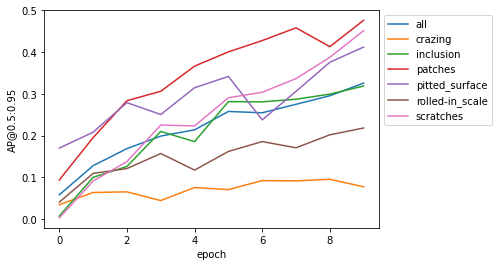

Epoch: [10]  [0/315]  Elapsed time: 1.2046942710876465  lr: 0.005  loss: 0.24416989088058472  loss_classifier: 0.08326463401317596  loss_box_reg: 0.11231645941734314  loss_objectness: 0.017769090831279755  loss_rpn_box_reg: 0.030819712206721306
Epoch: [10]  [10/315]  Elapsed time: 13.893158674240112  lr: 0.005  loss: 0.3913723826408386  loss_classifier: 0.10738835483789444  loss_box_reg: 0.1575728803873062  loss_objectness: 0.07534459233283997  loss_rpn_box_reg: 0.05106654018163681
Epoch: [10]  [20/315]  Elapsed time: 26.466012954711914  lr: 0.005  loss: 0.2670460045337677  loss_classifier: 0.09531978517770767  loss_box_reg: 0.11785485595464706  loss_objectness: 0.033183276653289795  loss_rpn_box_reg: 0.020688090473413467
Epoch: [10]  [30/315]  Elapsed time: 39.108585834503174  lr: 0.005  loss: 0.36053359508514404  loss_classifier: 0.11860678344964981  loss_box_reg: 0.18372666835784912  loss_objectness: 0.03027164563536644  loss_rpn_box_reg: 0.02792849950492382
Epoch: [10]  [40/315]  E

<Figure size 504x360 with 0 Axes>

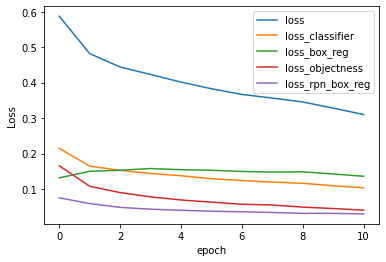

Test: [10] [0/135] Elapsed time: 0.49091076850891113 FPS: 12.314068184870854
Test: [10] [10/135] Elapsed time: 3.986687660217285 FPS: 11.424473266858831
Test: [10] [20/135] Elapsed time: 7.692832946777344 FPS: 11.542592560741106
Test: [10] [30/135] Elapsed time: 11.169423341751099 FPS: 12.31829048382644
Test: [10] [40/135] Elapsed time: 14.630198001861572 FPS: 10.215346995836464
Test: [10] [50/135] Elapsed time: 18.11089539527893 FPS: 13.193524820603558
Test: [10] [60/135] Elapsed time: 21.594650268554688 FPS: 12.519843289429499
Test: [10] [70/135] Elapsed time: 25.215692281723022 FPS: 9.833255869429266
Test: [10] [80/135] Elapsed time: 28.84778666496277 FPS: 10.442657929396416
Test: [10] [90/135] Elapsed time: 32.40659308433533 FPS: 11.465360391882434
Test: [10] [100/135] Elapsed time: 36.03460955619812 FPS: 10.600852126430135
Test: [10] [110/135] Elapsed time: 39.64000844955444 FPS: 13.834585771760722
Test: [10] [120/135] Elapsed time: 43.26244616508484 FPS: 11.001106850407332
Test: 

<Figure size 504x360 with 0 Axes>

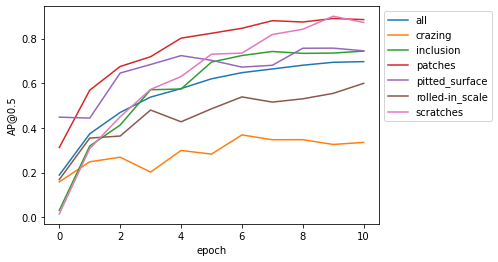

<Figure size 504x360 with 0 Axes>

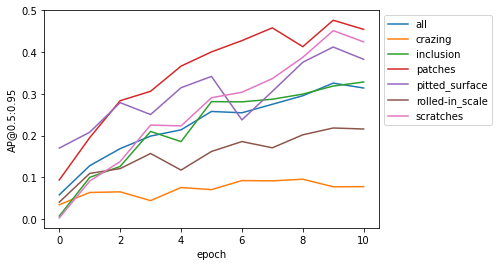

Epoch: [11]  [0/315]  Elapsed time: 1.1781971454620361  lr: 0.005  loss: 0.23077769577503204  loss_classifier: 0.07017828524112701  loss_box_reg: 0.11421837657690048  loss_objectness: 0.030114632099866867  loss_rpn_box_reg: 0.016266409307718277
Epoch: [11]  [10/315]  Elapsed time: 13.822014093399048  lr: 0.005  loss: 0.22241367399692535  loss_classifier: 0.07879094034433365  loss_box_reg: 0.0959150642156601  loss_objectness: 0.03281630575656891  loss_rpn_box_reg: 0.014891349710524082
Epoch: [11]  [20/315]  Elapsed time: 26.545326471328735  lr: 0.005  loss: 0.2908622920513153  loss_classifier: 0.09482578188180923  loss_box_reg: 0.15279808640480042  loss_objectness: 0.027211064472794533  loss_rpn_box_reg: 0.01602737233042717
Epoch: [11]  [30/315]  Elapsed time: 39.28014659881592  lr: 0.005  loss: 0.24688580632209778  loss_classifier: 0.08185119181871414  loss_box_reg: 0.10998871922492981  loss_objectness: 0.041312798857688904  loss_rpn_box_reg: 0.013733102940022945
Epoch: [11]  [40/315] 

<Figure size 504x360 with 0 Axes>

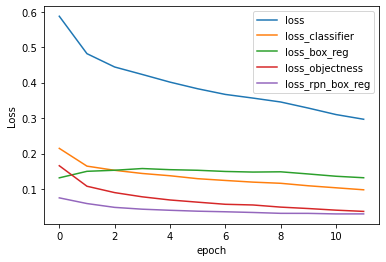

Test: [11] [0/135] Elapsed time: 0.5016155242919922 FPS: 11.66300150365068
Test: [11] [10/135] Elapsed time: 4.06679630279541 FPS: 11.509240819720151
Test: [11] [20/135] Elapsed time: 7.846608877182007 FPS: 11.69397409473412
Test: [11] [30/135] Elapsed time: 11.30652117729187 FPS: 12.888518096853543
Test: [11] [40/135] Elapsed time: 14.838292837142944 FPS: 10.636087806028454
Test: [11] [50/135] Elapsed time: 18.39802622795105 FPS: 13.22634039433333
Test: [11] [60/135] Elapsed time: 21.891953468322754 FPS: 11.750569240757848
Test: [11] [70/135] Elapsed time: 25.5804762840271 FPS: 9.943426855382105
Test: [11] [80/135] Elapsed time: 29.19738793373108 FPS: 10.601957453692469
Test: [11] [90/135] Elapsed time: 32.768677949905396 FPS: 10.928095141010802
Test: [11] [100/135] Elapsed time: 36.38105225563049 FPS: 10.815030358663483
Test: [11] [110/135] Elapsed time: 39.99538612365723 FPS: 13.434433410045626
Test: [11] [120/135] Elapsed time: 43.58959674835205 FPS: 10.605261411239523
Test: [11] [

<Figure size 504x360 with 0 Axes>

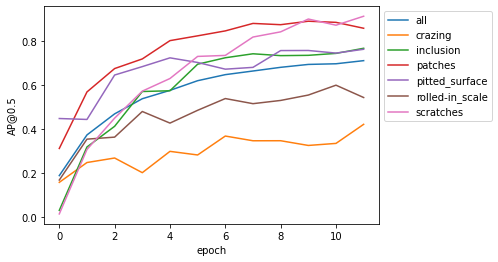

<Figure size 504x360 with 0 Axes>

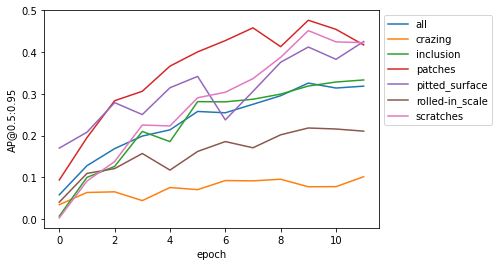

Epoch: [12]  [0/315]  Elapsed time: 1.2053663730621338  lr: 0.005  loss: 0.23498865962028503  loss_classifier: 0.0654851570725441  loss_box_reg: 0.0614902637898922  loss_objectness: 0.061440445482730865  loss_rpn_box_reg: 0.046572811901569366
Epoch: [12]  [10/315]  Elapsed time: 13.843204975128174  lr: 0.005  loss: 0.24368581175804138  loss_classifier: 0.0860656201839447  loss_box_reg: 0.11782070994377136  loss_objectness: 0.025669243186712265  loss_rpn_box_reg: 0.014130241237580776
Epoch: [12]  [20/315]  Elapsed time: 26.59205675125122  lr: 0.005  loss: 0.3015049695968628  loss_classifier: 0.07912171632051468  loss_box_reg: 0.14389370381832123  loss_objectness: 0.04221402481198311  loss_rpn_box_reg: 0.03627551347017288
Epoch: [12]  [30/315]  Elapsed time: 39.33679437637329  lr: 0.005  loss: 0.23376354575157166  loss_classifier: 0.06945840269327164  loss_box_reg: 0.09940233826637268  loss_objectness: 0.018979519605636597  loss_rpn_box_reg: 0.045923296362161636
Epoch: [12]  [40/315]  El

<Figure size 504x360 with 0 Axes>

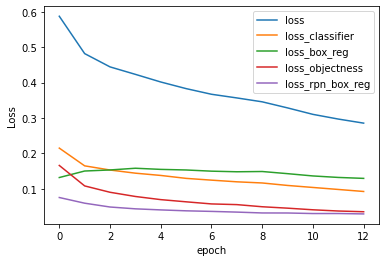

Test: [12] [0/135] Elapsed time: 0.49629688262939453 FPS: 12.561463301412838
Test: [12] [10/135] Elapsed time: 4.044788360595703 FPS: 11.916922849625811
Test: [12] [20/135] Elapsed time: 7.78619384765625 FPS: 11.054573056628836
Test: [12] [30/135] Elapsed time: 11.356147050857544 FPS: 11.918031820316157
Test: [12] [40/135] Elapsed time: 14.908722877502441 FPS: 11.10466460068863
Test: [12] [50/135] Elapsed time: 18.45693349838257 FPS: 13.043470418750884
Test: [12] [60/135] Elapsed time: 22.03968334197998 FPS: 11.808346465670931
Test: [12] [70/135] Elapsed time: 25.700127601623535 FPS: 10.36117976480295
Test: [12] [80/135] Elapsed time: 29.35927963256836 FPS: 10.595964654888752
Test: [12] [90/135] Elapsed time: 32.957207441329956 FPS: 10.774496298622523
Test: [12] [100/135] Elapsed time: 36.58524751663208 FPS: 10.567073631595125
Test: [12] [110/135] Elapsed time: 40.263421297073364 FPS: 13.287200038014984
Test: [12] [120/135] Elapsed time: 43.91119861602783 FPS: 10.952171931936428
Test: 

<Figure size 504x360 with 0 Axes>

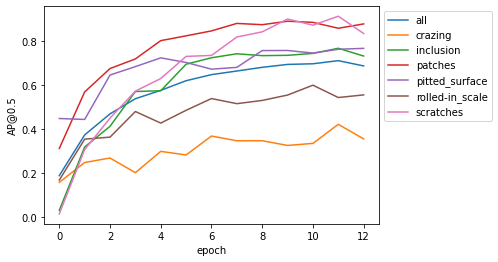

<Figure size 504x360 with 0 Axes>

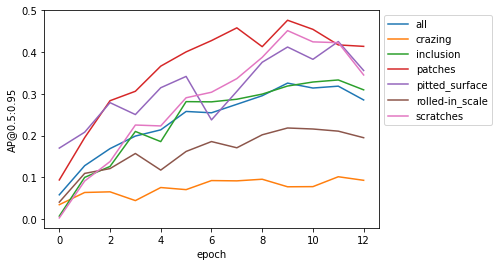

Epoch: [13]  [0/315]  Elapsed time: 1.1903223991394043  lr: 0.005  loss: 0.2544686794281006  loss_classifier: 0.08529897034168243  loss_box_reg: 0.1089431419968605  loss_objectness: 0.023278944194316864  loss_rpn_box_reg: 0.036947622895240784
Epoch: [13]  [10/315]  Elapsed time: 13.886078357696533  lr: 0.005  loss: 0.19456534087657928  loss_classifier: 0.06403501331806183  loss_box_reg: 0.06617677956819534  loss_objectness: 0.027037672698497772  loss_rpn_box_reg: 0.03731586039066315
Epoch: [13]  [20/315]  Elapsed time: 26.604480743408203  lr: 0.005  loss: 0.2793770134449005  loss_classifier: 0.08538364619016647  loss_box_reg: 0.1368614286184311  loss_objectness: 0.026106754317879677  loss_rpn_box_reg: 0.031025197356939316
Epoch: [13]  [30/315]  Elapsed time: 39.33367657661438  lr: 0.005  loss: 0.2849598228931427  loss_classifier: 0.09289506077766418  loss_box_reg: 0.14263449609279633  loss_objectness: 0.022364530712366104  loss_rpn_box_reg: 0.02706572227180004
Epoch: [13]  [40/315]  El

<Figure size 504x360 with 0 Axes>

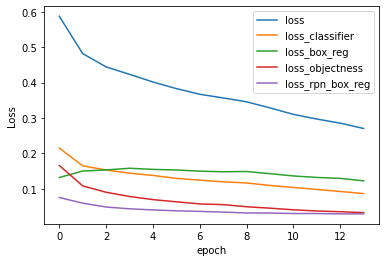

Test: [13] [0/135] Elapsed time: 0.5182216167449951 FPS: 11.520091406975276
Test: [13] [10/135] Elapsed time: 4.132651090621948 FPS: 11.920631514626157
Test: [13] [20/135] Elapsed time: 7.983046531677246 FPS: 11.786338224281076
Test: [13] [30/135] Elapsed time: 11.626827955245972 FPS: 11.737596695577102
Test: [13] [40/135] Elapsed time: 15.280022382736206 FPS: 10.748465943235095
Test: [13] [50/135] Elapsed time: 18.95200490951538 FPS: 12.449432299245563
Test: [13] [60/135] Elapsed time: 22.573177099227905 FPS: 11.49170822656532
Test: [13] [70/135] Elapsed time: 26.386337995529175 FPS: 9.451212552932475
Test: [13] [80/135] Elapsed time: 30.157196044921875 FPS: 9.889427520513062
Test: [13] [90/135] Elapsed time: 33.853697299957275 FPS: 10.645927986557762
Test: [13] [100/135] Elapsed time: 37.7003493309021 FPS: 9.869449866287354
Test: [13] [110/135] Elapsed time: 41.4548397064209 FPS: 13.50027962608159
Test: [13] [120/135] Elapsed time: 45.24530076980591 FPS: 10.197285175683158
Test: [13]

<Figure size 504x360 with 0 Axes>

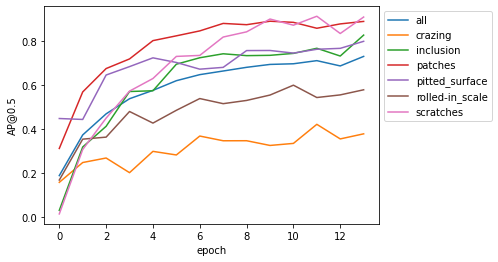

<Figure size 504x360 with 0 Axes>

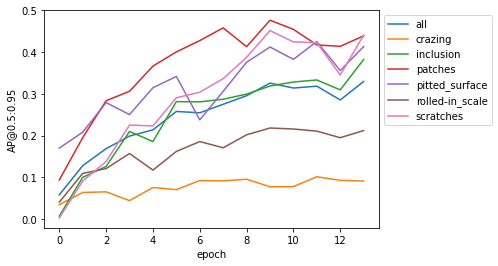

Epoch: [14]  [0/315]  Elapsed time: 1.188870906829834  lr: 0.005  loss: 0.2205713987350464  loss_classifier: 0.06894662231206894  loss_box_reg: 0.11074652522802353  loss_objectness: 0.016403336077928543  loss_rpn_box_reg: 0.02447492629289627
Epoch: [14]  [10/315]  Elapsed time: 13.89829158782959  lr: 0.005  loss: 0.21683692932128906  loss_classifier: 0.07714007794857025  loss_box_reg: 0.09322120249271393  loss_objectness: 0.017657656222581863  loss_rpn_box_reg: 0.02881799265742302
Epoch: [14]  [20/315]  Elapsed time: 26.659754037857056  lr: 0.005  loss: 0.25014159083366394  loss_classifier: 0.08141499012708664  loss_box_reg: 0.12372608482837677  loss_objectness: 0.03291797265410423  loss_rpn_box_reg: 0.012082538567483425
Epoch: [14]  [30/315]  Elapsed time: 39.427329301834106  lr: 0.005  loss: 0.29100438952445984  loss_classifier: 0.09970758855342865  loss_box_reg: 0.11273825913667679  loss_objectness: 0.04377318173646927  loss_rpn_box_reg: 0.03478536009788513
Epoch: [14]  [40/315]  El

<Figure size 504x360 with 0 Axes>

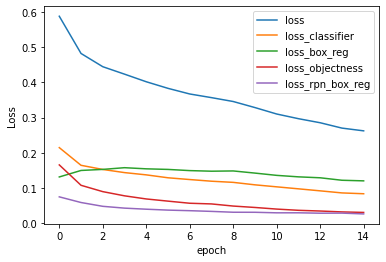

Test: [14] [0/135] Elapsed time: 0.49315714836120605 FPS: 12.263777841129215
Test: [14] [10/135] Elapsed time: 4.039839267730713 FPS: 12.258293987763052
Test: [14] [20/135] Elapsed time: 7.754632472991943 FPS: 10.952715327075714
Test: [14] [30/135] Elapsed time: 11.284751653671265 FPS: 12.878861804844423
Test: [14] [40/135] Elapsed time: 14.881564617156982 FPS: 10.692622141097202
Test: [14] [50/135] Elapsed time: 18.411775588989258 FPS: 12.803067141023469
Test: [14] [60/135] Elapsed time: 21.930678844451904 FPS: 12.598250369825262
Test: [14] [70/135] Elapsed time: 25.581395864486694 FPS: 9.79352317708379
Test: [14] [80/135] Elapsed time: 29.242997884750366 FPS: 10.776676378846973
Test: [14] [90/135] Elapsed time: 32.85731077194214 FPS: 11.361766390950253
Test: [14] [100/135] Elapsed time: 36.52961254119873 FPS: 10.989418800395633
Test: [14] [110/135] Elapsed time: 40.16247367858887 FPS: 13.242333879005919
Test: [14] [120/135] Elapsed time: 43.76772141456604 FPS: 10.561751804231445
Test

<Figure size 504x360 with 0 Axes>

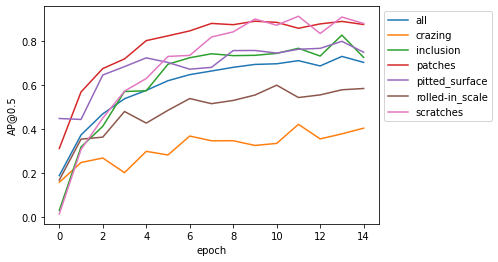

<Figure size 504x360 with 0 Axes>

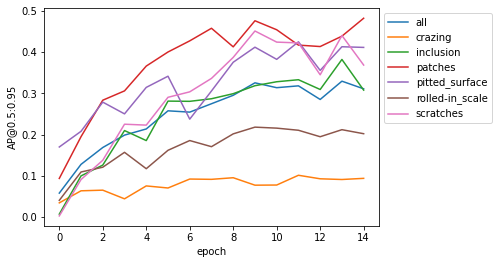

Epoch: [15]  [0/315]  Elapsed time: 1.211395263671875  lr: 0.005  loss: 0.13776594400405884  loss_classifier: 0.04428447410464287  loss_box_reg: 0.06794454902410507  loss_objectness: 0.015238378196954727  loss_rpn_box_reg: 0.010298548266291618
Epoch: [15]  [10/315]  Elapsed time: 14.22108268737793  lr: 0.005  loss: 0.2319735735654831  loss_classifier: 0.06779611110687256  loss_box_reg: 0.12470566481351852  loss_objectness: 0.01988101191818714  loss_rpn_box_reg: 0.019590776413679123
Epoch: [15]  [20/315]  Elapsed time: 26.88710117340088  lr: 0.005  loss: 0.16292785108089447  loss_classifier: 0.04015977680683136  loss_box_reg: 0.06872870028018951  loss_objectness: 0.014154213480651379  loss_rpn_box_reg: 0.03988516703248024
Epoch: [15]  [30/315]  Elapsed time: 39.626084089279175  lr: 0.005  loss: 0.22893638908863068  loss_classifier: 0.08863839507102966  loss_box_reg: 0.09292958676815033  loss_objectness: 0.019323036074638367  loss_rpn_box_reg: 0.02804536558687687
Epoch: [15]  [40/315]  E

<Figure size 504x360 with 0 Axes>

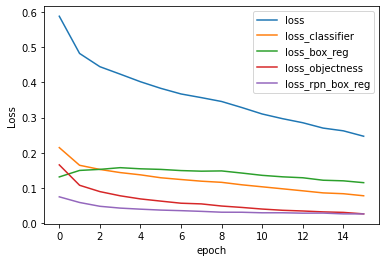

Test: [15] [0/135] Elapsed time: 0.514310359954834 FPS: 11.929217710219802
Test: [15] [10/135] Elapsed time: 4.116956472396851 FPS: 11.986268515535082
Test: [15] [20/135] Elapsed time: 7.9291300773620605 FPS: 12.101237372917726
Test: [15] [30/135] Elapsed time: 11.590007781982422 FPS: 11.510251518089119
Test: [15] [40/135] Elapsed time: 15.20779538154602 FPS: 11.366669805779264
Test: [15] [50/135] Elapsed time: 18.850723266601562 FPS: 12.518946443148732
Test: [15] [60/135] Elapsed time: 22.47062039375305 FPS: 11.871321260974657
Test: [15] [70/135] Elapsed time: 26.14158797264099 FPS: 10.891665130241266
Test: [15] [80/135] Elapsed time: 29.836951971054077 FPS: 10.482851008845046
Test: [15] [90/135] Elapsed time: 33.44142532348633 FPS: 11.834567892525985
Test: [15] [100/135] Elapsed time: 37.20875787734985 FPS: 10.521460631103915
Test: [15] [110/135] Elapsed time: 40.905694246292114 FPS: 12.35618526748068
Test: [15] [120/135] Elapsed time: 44.5569863319397 FPS: 10.618061040565445
Test: [

<Figure size 504x360 with 0 Axes>

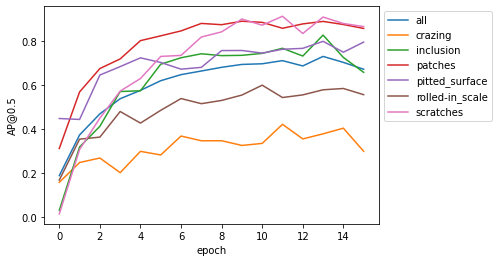

<Figure size 504x360 with 0 Axes>

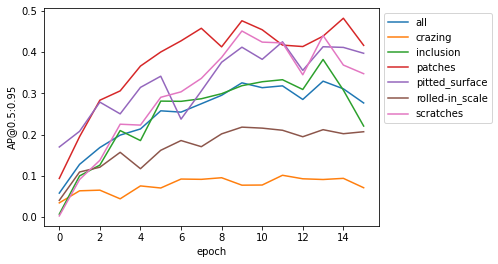

Epoch: [16]  [0/315]  Elapsed time: 1.196977138519287  lr: 0.005  loss: 0.2686944603919983  loss_classifier: 0.08392402529716492  loss_box_reg: 0.14587163925170898  loss_objectness: 0.022246472537517548  loss_rpn_box_reg: 0.01665232889354229
Epoch: [16]  [10/315]  Elapsed time: 13.90743088722229  lr: 0.005  loss: 0.2775421440601349  loss_classifier: 0.07371543347835541  loss_box_reg: 0.10272803902626038  loss_objectness: 0.035666804760694504  loss_rpn_box_reg: 0.0654318556189537
Epoch: [16]  [20/315]  Elapsed time: 26.70040011405945  lr: 0.005  loss: 0.2631656229496002  loss_classifier: 0.07992641627788544  loss_box_reg: 0.11797928810119629  loss_objectness: 0.030070852488279343  loss_rpn_box_reg: 0.03518906980752945
Epoch: [16]  [30/315]  Elapsed time: 39.41442394256592  lr: 0.005  loss: 0.18472254276275635  loss_classifier: 0.05571681633591652  loss_box_reg: 0.08828173577785492  loss_objectness: 0.01683693565428257  loss_rpn_box_reg: 0.02388705499470234
Epoch: [16]  [40/315]  Elapsed

<Figure size 504x360 with 0 Axes>

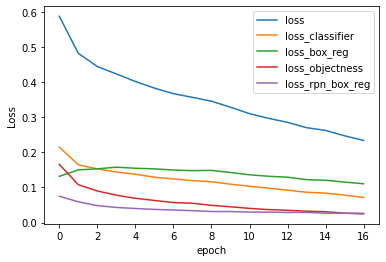

Test: [16] [0/135] Elapsed time: 0.50234055519104 FPS: 12.048399803229477
Test: [16] [10/135] Elapsed time: 4.037408351898193 FPS: 12.177089192745663
Test: [16] [20/135] Elapsed time: 7.723016023635864 FPS: 11.409447474849827
Test: [16] [30/135] Elapsed time: 11.241553783416748 FPS: 12.044075133615939
Test: [16] [40/135] Elapsed time: 14.780001401901245 FPS: 11.039268944897143
Test: [16] [50/135] Elapsed time: 18.336799383163452 FPS: 12.664601848070516
Test: [16] [60/135] Elapsed time: 21.8303542137146 FPS: 12.447751205473171
Test: [16] [70/135] Elapsed time: 25.36363983154297 FPS: 10.278840516134883
Test: [16] [80/135] Elapsed time: 28.973098039627075 FPS: 10.220742534056011
Test: [16] [90/135] Elapsed time: 32.41375136375427 FPS: 11.428068533470112
Test: [16] [100/135] Elapsed time: 36.0451717376709 FPS: 10.718122190258434
Test: [16] [110/135] Elapsed time: 39.66073393821716 FPS: 12.261133868050354
Test: [16] [120/135] Elapsed time: 43.24135065078735 FPS: 11.0937237984654
Test: [16] 

<Figure size 504x360 with 0 Axes>

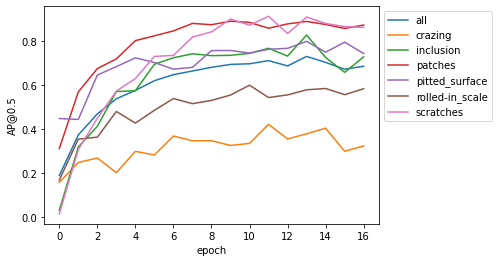

<Figure size 504x360 with 0 Axes>

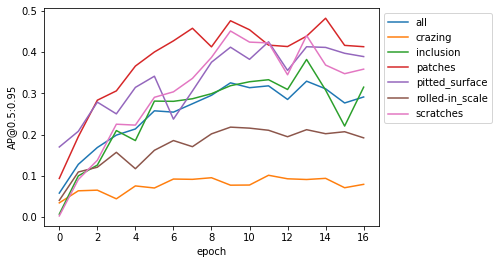

Epoch: [17]  [0/315]  Elapsed time: 1.1932072639465332  lr: 0.005  loss: 0.20939545333385468  loss_classifier: 0.06136724725365639  loss_box_reg: 0.12065538763999939  loss_objectness: 0.017944756895303726  loss_rpn_box_reg: 0.009428070858120918
Epoch: [17]  [10/315]  Elapsed time: 13.893130779266357  lr: 0.005  loss: 0.21421664953231812  loss_classifier: 0.0713752880692482  loss_box_reg: 0.1053621917963028  loss_objectness: 0.013213190250098705  loss_rpn_box_reg: 0.024265971034765244
Epoch: [17]  [20/315]  Elapsed time: 26.60399055480957  lr: 0.005  loss: 0.1662152111530304  loss_classifier: 0.04664545878767967  loss_box_reg: 0.0829489529132843  loss_objectness: 0.025081399828195572  loss_rpn_box_reg: 0.011539406143128872
Epoch: [17]  [30/315]  Elapsed time: 39.314531564712524  lr: 0.005  loss: 0.20725823938846588  loss_classifier: 0.06513548642396927  loss_box_reg: 0.10630340874195099  loss_objectness: 0.01820804923772812  loss_rpn_box_reg: 0.017611276358366013
Epoch: [17]  [40/315]  

<Figure size 504x360 with 0 Axes>

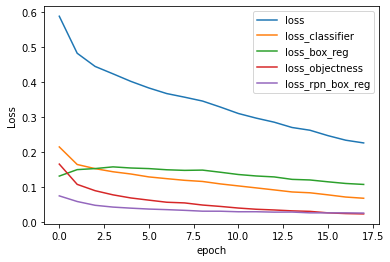

Test: [17] [0/135] Elapsed time: 0.49727940559387207 FPS: 12.065703551558878
Test: [17] [10/135] Elapsed time: 3.986302614212036 FPS: 12.286311232123124
Test: [17] [20/135] Elapsed time: 7.698065996170044 FPS: 12.2496838502224
Test: [17] [30/135] Elapsed time: 11.250324249267578 FPS: 12.552769661849483
Test: [17] [40/135] Elapsed time: 14.783827543258667 FPS: 10.54588472529006
Test: [17] [50/135] Elapsed time: 18.361494541168213 FPS: 13.300082366380565
Test: [17] [60/135] Elapsed time: 21.890291452407837 FPS: 12.306814764173158
Test: [17] [70/135] Elapsed time: 25.511141300201416 FPS: 10.39040208486614
Test: [17] [80/135] Elapsed time: 29.14737606048584 FPS: 10.784982601669185
Test: [17] [90/135] Elapsed time: 32.71177315711975 FPS: 11.496432978995314
Test: [17] [100/135] Elapsed time: 36.34142065048218 FPS: 10.590119003959645
Test: [17] [110/135] Elapsed time: 39.94191551208496 FPS: 12.92391266668875
Test: [17] [120/135] Elapsed time: 43.56397032737732 FPS: 11.285203840027553
Test: [1

<Figure size 504x360 with 0 Axes>

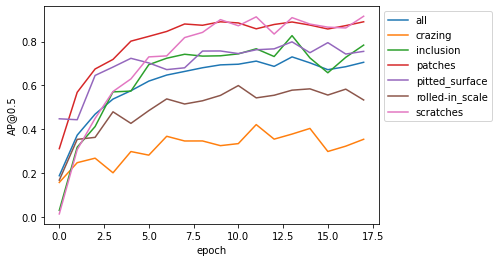

<Figure size 504x360 with 0 Axes>

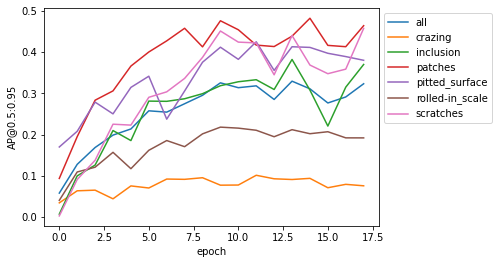

Epoch: [18]  [0/315]  Elapsed time: 1.2023885250091553  lr: 0.005  loss: 0.21671871840953827  loss_classifier: 0.06579583883285522  loss_box_reg: 0.12260223925113678  loss_objectness: 0.010451599955558777  loss_rpn_box_reg: 0.017869042232632637
Epoch: [18]  [10/315]  Elapsed time: 13.871108055114746  lr: 0.005  loss: 0.1305917203426361  loss_classifier: 0.03152314946055412  loss_box_reg: 0.05067542940378189  loss_objectness: 0.019045118242502213  loss_rpn_box_reg: 0.029348036274313927
Epoch: [18]  [20/315]  Elapsed time: 26.611745834350586  lr: 0.005  loss: 0.3017038106918335  loss_classifier: 0.1002669557929039  loss_box_reg: 0.17277248203754425  loss_objectness: 0.015462320297956467  loss_rpn_box_reg: 0.013202070258557796
Epoch: [18]  [30/315]  Elapsed time: 39.296813011169434  lr: 0.005  loss: 0.1848008632659912  loss_classifier: 0.044148679822683334  loss_box_reg: 0.07792386412620544  loss_objectness: 0.019345678389072418  loss_rpn_box_reg: 0.04338264837861061
Epoch: [18]  [40/315]

<Figure size 504x360 with 0 Axes>

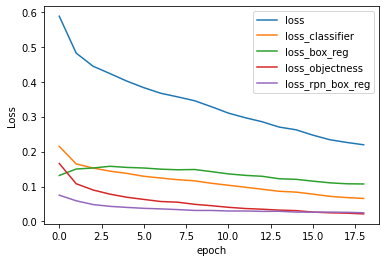

Test: [18] [0/135] Elapsed time: 0.49080801010131836 FPS: 12.535165554403278
Test: [18] [10/135] Elapsed time: 4.028369903564453 FPS: 11.948639388196517
Test: [18] [20/135] Elapsed time: 7.735652208328247 FPS: 11.517655555341976
Test: [18] [30/135] Elapsed time: 11.294411182403564 FPS: 12.109998397577021
Test: [18] [40/135] Elapsed time: 14.857703447341919 FPS: 11.231797017523306
Test: [18] [50/135] Elapsed time: 18.462149620056152 FPS: 12.684374310106541
Test: [18] [60/135] Elapsed time: 21.95844531059265 FPS: 12.26203000237534
Test: [18] [70/135] Elapsed time: 25.63213348388672 FPS: 10.242519369693595
Test: [18] [80/135] Elapsed time: 29.295087099075317 FPS: 10.881570319386224
Test: [18] [90/135] Elapsed time: 32.879148960113525 FPS: 11.569584184415845
Test: [18] [100/135] Elapsed time: 36.546146869659424 FPS: 10.651733987526896
Test: [18] [110/135] Elapsed time: 40.168620586395264 FPS: 12.972197930753463
Test: [18] [120/135] Elapsed time: 43.7630181312561 FPS: 10.67336439174312
Test

<Figure size 504x360 with 0 Axes>

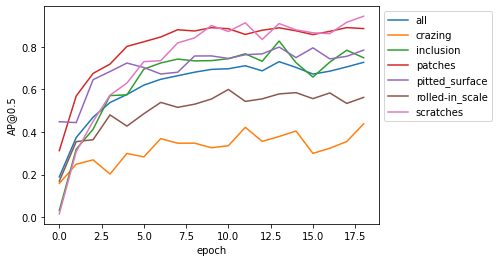

<Figure size 504x360 with 0 Axes>

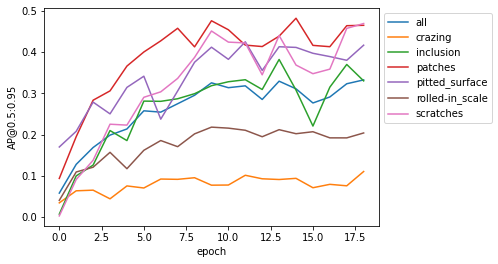

Epoch: [19]  [0/315]  Elapsed time: 1.1627326011657715  lr: 0.005  loss: 0.1497083604335785  loss_classifier: 0.05286771059036255  loss_box_reg: 0.05076436698436737  loss_objectness: 0.024146070703864098  loss_rpn_box_reg: 0.021930214017629623
Epoch: [19]  [10/315]  Elapsed time: 13.856369733810425  lr: 0.005  loss: 0.22058814764022827  loss_classifier: 0.0686357319355011  loss_box_reg: 0.11664608865976334  loss_objectness: 0.01116903219372034  loss_rpn_box_reg: 0.024137301370501518
Epoch: [19]  [20/315]  Elapsed time: 26.571961164474487  lr: 0.005  loss: 0.22747987508773804  loss_classifier: 0.06514724344015121  loss_box_reg: 0.07726724445819855  loss_objectness: 0.03576067090034485  loss_rpn_box_reg: 0.049304716289043427
Epoch: [19]  [30/315]  Elapsed time: 39.28299164772034  lr: 0.005  loss: 0.13801538944244385  loss_classifier: 0.04535280168056488  loss_box_reg: 0.06177603453397751  loss_objectness: 0.013469001278281212  loss_rpn_box_reg: 0.0174175463616848
Epoch: [19]  [40/315]  E

<Figure size 504x360 with 0 Axes>

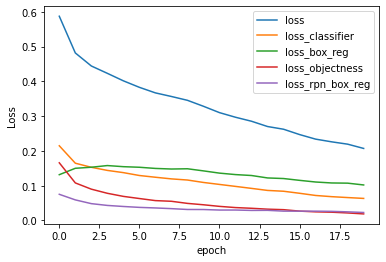

Test: [19] [0/135] Elapsed time: 0.5141236782073975 FPS: 11.548917229809962
Test: [19] [10/135] Elapsed time: 4.205064535140991 FPS: 11.507709318332875
Test: [19] [20/135] Elapsed time: 8.136250257492065 FPS: 10.399779820335377
Test: [19] [30/135] Elapsed time: 11.868759632110596 FPS: 11.234843168242573
Test: [19] [40/135] Elapsed time: 15.571770429611206 FPS: 10.422307688006953
Test: [19] [50/135] Elapsed time: 19.280961275100708 FPS: 12.21703619988582
Test: [19] [60/135] Elapsed time: 22.94884204864502 FPS: 11.471875224364343
Test: [19] [70/135] Elapsed time: 26.7796630859375 FPS: 9.634514513318853
Test: [19] [80/135] Elapsed time: 30.515782117843628 FPS: 10.419595568142297
Test: [19] [90/135] Elapsed time: 34.22643065452576 FPS: 10.548291591088422
Test: [19] [100/135] Elapsed time: 38.046534299850464 FPS: 10.563786770030134
Test: [19] [110/135] Elapsed time: 41.841514110565186 FPS: 12.415556506076344
Test: [19] [120/135] Elapsed time: 45.63291645050049 FPS: 10.489391951963368
Test: 

<Figure size 504x360 with 0 Axes>

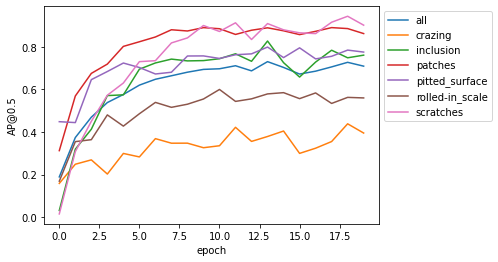

<Figure size 504x360 with 0 Axes>

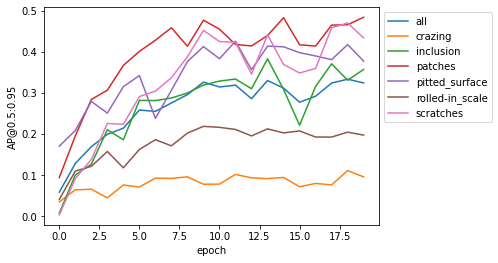

Epoch: [20]  [0/315]  Elapsed time: 1.2044346332550049  lr: 0.005  loss: 0.19697943329811096  loss_classifier: 0.0597030445933342  loss_box_reg: 0.1105099469423294  loss_objectness: 0.011667763814330101  loss_rpn_box_reg: 0.015098691917955875
Epoch: [20]  [10/315]  Elapsed time: 13.875659942626953  lr: 0.005  loss: 0.09838864952325821  loss_classifier: 0.02557823434472084  loss_box_reg: 0.038964785635471344  loss_objectness: 0.018113121390342712  loss_rpn_box_reg: 0.015732504427433014
Epoch: [20]  [20/315]  Elapsed time: 26.576494455337524  lr: 0.005  loss: 0.1917046308517456  loss_classifier: 0.05859849229454994  loss_box_reg: 0.10542972385883331  loss_objectness: 0.013060323894023895  loss_rpn_box_reg: 0.014616107568144798
Epoch: [20]  [30/315]  Elapsed time: 39.30574703216553  lr: 0.005  loss: 0.1931041032075882  loss_classifier: 0.07314945012331009  loss_box_reg: 0.10449512302875519  loss_objectness: 0.006679224781692028  loss_rpn_box_reg: 0.00878030527383089
Epoch: [20]  [40/315] 

<Figure size 504x360 with 0 Axes>

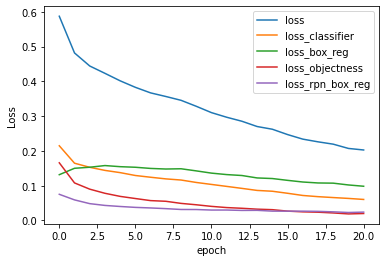

Test: [20] [0/135] Elapsed time: 0.5137343406677246 FPS: 11.882066151172326
Test: [20] [10/135] Elapsed time: 4.350447416305542 FPS: 11.260707837491358
Test: [20] [20/135] Elapsed time: 8.315906047821045 FPS: 11.189898340445456
Test: [20] [30/135] Elapsed time: 12.074697971343994 FPS: 11.621073513755386
Test: [20] [40/135] Elapsed time: 15.843446254730225 FPS: 11.090746349957229
Test: [20] [50/135] Elapsed time: 19.64141011238098 FPS: 11.969832159101044
Test: [20] [60/135] Elapsed time: 23.41719651222229 FPS: 10.897154838022443
Test: [20] [70/135] Elapsed time: 27.314037084579468 FPS: 9.455484499280576
Test: [20] [80/135] Elapsed time: 31.172627925872803 FPS: 10.442768427729092
Test: [20] [90/135] Elapsed time: 34.99148654937744 FPS: 10.3136699704985
Test: [20] [100/135] Elapsed time: 38.91307616233826 FPS: 10.935403278949245
Test: [20] [110/135] Elapsed time: 42.72917127609253 FPS: 11.916990567109899
Test: [20] [120/135] Elapsed time: 46.63252282142639 FPS: 9.628017934728652
Test: [20

<Figure size 504x360 with 0 Axes>

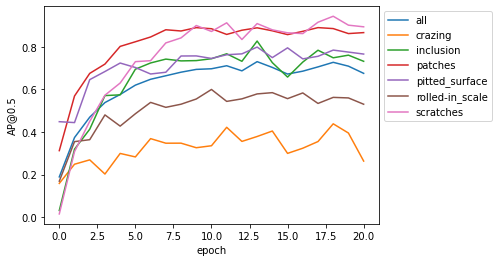

<Figure size 504x360 with 0 Axes>

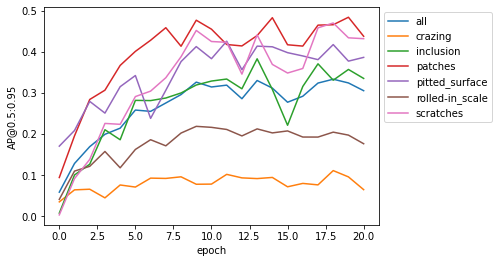

Epoch: [21]  [0/315]  Elapsed time: 1.1926307678222656  lr: 0.005  loss: 0.1906423568725586  loss_classifier: 0.06221656873822212  loss_box_reg: 0.08784051239490509  loss_objectness: 0.02167154848575592  loss_rpn_box_reg: 0.018913723528385162
Epoch: [21]  [10/315]  Elapsed time: 13.860134601593018  lr: 0.005  loss: 0.12612074613571167  loss_classifier: 0.03737354278564453  loss_box_reg: 0.061566952615976334  loss_objectness: 0.011671043001115322  loss_rpn_box_reg: 0.015509214252233505
Epoch: [21]  [20/315]  Elapsed time: 26.551781177520752  lr: 0.005  loss: 0.2716071605682373  loss_classifier: 0.08288861811161041  loss_box_reg: 0.1591392606496811  loss_objectness: 0.010570812970399857  loss_rpn_box_reg: 0.019008465111255646
Epoch: [21]  [30/315]  Elapsed time: 39.28064560890198  lr: 0.005  loss: 0.16442707180976868  loss_classifier: 0.04612240195274353  loss_box_reg: 0.09391151368618011  loss_objectness: 0.008646689355373383  loss_rpn_box_reg: 0.015746477991342545
Epoch: [21]  [40/315]

<Figure size 504x360 with 0 Axes>

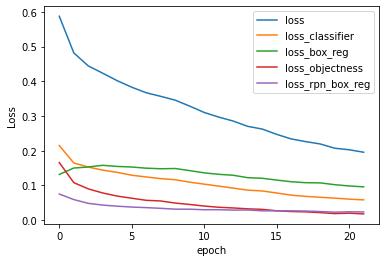

Test: [21] [0/135] Elapsed time: 0.5006513595581055 FPS: 12.039468453224142
Test: [21] [10/135] Elapsed time: 4.147976875305176 FPS: 11.038157703419042
Test: [21] [20/135] Elapsed time: 8.00190281867981 FPS: 10.845617591692353
Test: [21] [30/135] Elapsed time: 11.694169521331787 FPS: 11.010991160211567
Test: [21] [40/135] Elapsed time: 15.399137258529663 FPS: 10.855055782117502
Test: [21] [50/135] Elapsed time: 19.05087375640869 FPS: 12.89972604677734
Test: [21] [60/135] Elapsed time: 22.78608989715576 FPS: 10.44795147559768
Test: [21] [70/135] Elapsed time: 26.651155710220337 FPS: 9.76101671051514
Test: [21] [80/135] Elapsed time: 30.41697096824646 FPS: 10.334075153142777
Test: [21] [90/135] Elapsed time: 34.12238621711731 FPS: 11.247285589018468
Test: [21] [100/135] Elapsed time: 37.9757194519043 FPS: 10.390846115018132
Test: [21] [110/135] Elapsed time: 41.75407290458679 FPS: 12.876410461862463
Test: [21] [120/135] Elapsed time: 45.518868923187256 FPS: 10.281958725610004
Test: [21] 

<Figure size 504x360 with 0 Axes>

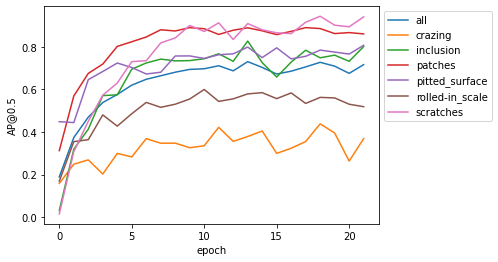

<Figure size 504x360 with 0 Axes>

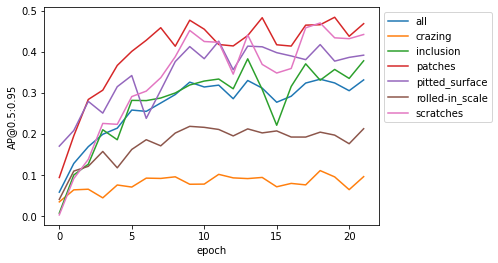

Epoch: [22]  [0/315]  Elapsed time: 1.2245707511901855  lr: 0.005  loss: 0.1743990182876587  loss_classifier: 0.06406987458467484  loss_box_reg: 0.0936053916811943  loss_objectness: 0.006102493032813072  loss_rpn_box_reg: 0.010621270164847374
Epoch: [22]  [10/315]  Elapsed time: 13.84905457496643  lr: 0.005  loss: 0.10233122855424881  loss_classifier: 0.03224022686481476  loss_box_reg: 0.046624504029750824  loss_objectness: 0.009585714899003506  loss_rpn_box_reg: 0.013880782760679722
Epoch: [22]  [20/315]  Elapsed time: 26.55868172645569  lr: 0.005  loss: 0.141470804810524  loss_classifier: 0.040248870849609375  loss_box_reg: 0.06705290079116821  loss_objectness: 0.006920673884451389  loss_rpn_box_reg: 0.027248363941907883
Epoch: [22]  [30/315]  Elapsed time: 39.255115270614624  lr: 0.005  loss: 0.2833866477012634  loss_classifier: 0.09367142617702484  loss_box_reg: 0.16458213329315186  loss_objectness: 0.015591355040669441  loss_rpn_box_reg: 0.009541713632643223
Epoch: [22]  [40/315] 

<Figure size 504x360 with 0 Axes>

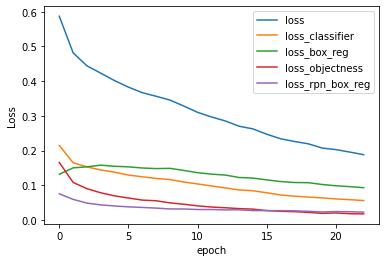

Test: [22] [0/135] Elapsed time: 0.5149922370910645 FPS: 11.660431910682117
Test: [22] [10/135] Elapsed time: 4.1709582805633545 FPS: 11.565181785469571
Test: [22] [20/135] Elapsed time: 7.972276210784912 FPS: 10.889728075106158
Test: [22] [30/135] Elapsed time: 11.592084646224976 FPS: 11.755764643891172
Test: [22] [40/135] Elapsed time: 15.196018695831299 FPS: 10.732012739823206
Test: [22] [50/135] Elapsed time: 18.83439874649048 FPS: 12.947510663403785
Test: [22] [60/135] Elapsed time: 22.424184799194336 FPS: 11.518691457246412
Test: [22] [70/135] Elapsed time: 26.14681315422058 FPS: 9.828658868438735
Test: [22] [80/135] Elapsed time: 29.824936151504517 FPS: 10.631033066858624
Test: [22] [90/135] Elapsed time: 33.40547227859497 FPS: 11.13126187620089
Test: [22] [100/135] Elapsed time: 37.13820004463196 FPS: 10.170783547027977
Test: [22] [110/135] Elapsed time: 40.79011344909668 FPS: 13.27867121603899
Test: [22] [120/135] Elapsed time: 44.487685680389404 FPS: 9.955268623239144
Test: [

<Figure size 504x360 with 0 Axes>

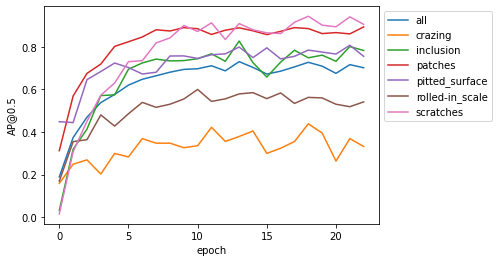

<Figure size 504x360 with 0 Axes>

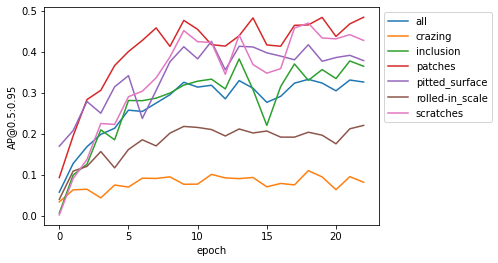

Epoch: [23]  [0/315]  Elapsed time: 1.2206404209136963  lr: 0.005  loss: 0.1452593207359314  loss_classifier: 0.04014763981103897  loss_box_reg: 0.07511571049690247  loss_objectness: 0.02000272274017334  loss_rpn_box_reg: 0.009993257001042366
Epoch: [23]  [10/315]  Elapsed time: 13.913600206375122  lr: 0.005  loss: 0.15766167640686035  loss_classifier: 0.05550582706928253  loss_box_reg: 0.07635200023651123  loss_objectness: 0.008853529579937458  loss_rpn_box_reg: 0.016950320452451706
Epoch: [23]  [20/315]  Elapsed time: 26.63019824028015  lr: 0.005  loss: 0.17550931870937347  loss_classifier: 0.0393698588013649  loss_box_reg: 0.08524981141090393  loss_objectness: 0.019046101719141006  loss_rpn_box_reg: 0.03184354305267334
Epoch: [23]  [30/315]  Elapsed time: 39.28657507896423  lr: 0.005  loss: 0.15753795206546783  loss_classifier: 0.04884815216064453  loss_box_reg: 0.09118206799030304  loss_objectness: 0.005910769570618868  loss_rpn_box_reg: 0.011596966534852982
Epoch: [23]  [40/315]  

<Figure size 504x360 with 0 Axes>

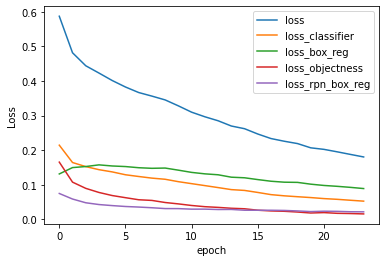

Test: [23] [0/135] Elapsed time: 0.5211601257324219 FPS: 11.253600173326152
Test: [23] [10/135] Elapsed time: 4.228045463562012 FPS: 10.789997466052174
Test: [23] [20/135] Elapsed time: 8.15208387374878 FPS: 10.571135130094426
Test: [23] [30/135] Elapsed time: 11.86660361289978 FPS: 11.533530815379951
Test: [23] [40/135] Elapsed time: 15.545046329498291 FPS: 10.551449366965214
Test: [23] [50/135] Elapsed time: 19.23792862892151 FPS: 12.209878834323458
Test: [23] [60/135] Elapsed time: 22.914332628250122 FPS: 11.348393983135571
Test: [23] [70/135] Elapsed time: 26.738168954849243 FPS: 9.535678620450547
Test: [23] [80/135] Elapsed time: 30.516419172286987 FPS: 10.26931493282521
Test: [23] [90/135] Elapsed time: 34.19776773452759 FPS: 10.866276633434177
Test: [23] [100/135] Elapsed time: 37.99180316925049 FPS: 10.195766899948223
Test: [23] [110/135] Elapsed time: 41.792720079422 FPS: 13.516899330729945
Test: [23] [120/135] Elapsed time: 45.55380034446716 FPS: 10.147646752486374
Test: [23]

<Figure size 504x360 with 0 Axes>

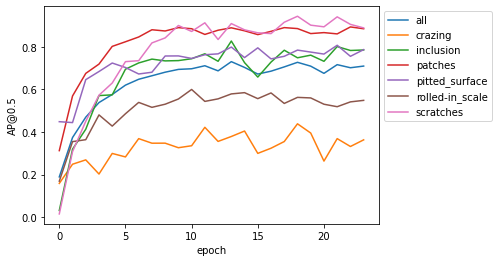

<Figure size 504x360 with 0 Axes>

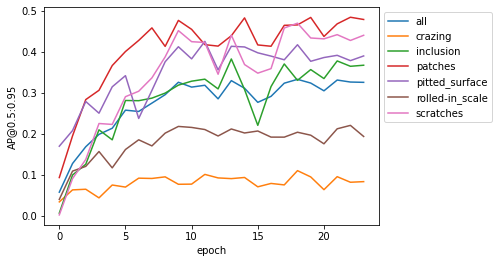

In [ ]:
train_tracker = Tracker(kind='train')
test_tracker = Tracker(kind='val')

for epoch in range(24):

    if len(list(Path('fasterrcnn').glob('train*'))) != 0:
        train_tracker.load_result('fasterrcnn/train0.csv', overwrite=True)
    loss = train_one_epoch(fasterrcnn_model, optimizer, data_loader, device, epoch, train_tracker, print_freq=10)
    train_tracker.save_result()
    
    plt.figure(figsize=(7, 5))
    train_tracker.data.plot.line(ylabel='Loss').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    lr_scheduler.step(loss)

    if len(list(Path('fasterrcnn').glob('val*'))) != 0:
        test_tracker.load_result('fasterrcnn/val0.csv', overwrite=True)    
    evaluate_one_epoch(fasterrcnn_model, data_loader_test, device, epoch, test_tracker, print_freq=10)
    test_tracker.save_result()

    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5', ylabel='AP@0.5').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5:0.95', ylabel='AP@0.5:0.95').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    

## Train with new anchor boxes

In [ ]:
def get_bboxes_dims(annotation_dir):
    buffer = []
    for xml_path in Path(annotation_dir).glob('*.xml'):
        info = extract_info_from_xml(xml_path)
        for bbox in info['bboxes']:
            buffer.append([bbox['xmax'] - bbox['xmin'], bbox['ymax'] - bbox['ymin']])
    return buffer

bboxes = get_bboxes_dims('surface_defect_detection/NEU-DET/ANNOTATIONS')

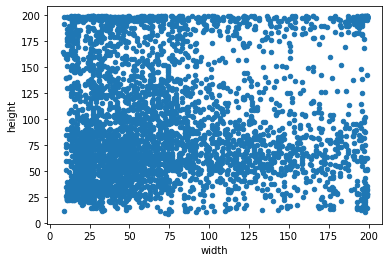

In [ ]:
bbox_dims = pd.DataFrame.from_dict(bboxes)
bbox_dims.columns = ['width', 'height']
bbox_dims.plot.scatter(x='width', y='height')

In [ ]:
bboxes = np.array(bboxes)

In [ ]:
def kmeans(bboxes, k, dist=np.median):
    """Cluster bboxes into k cluster using IoU as distance.
    Arguemnts:
        bboxes - array of shape (n, 2), each vector represents (w, h)
        k - number of clusters
        dist - metric to compute centroid of cluster
    Return:
        converged_clusters - array of shape (n,), each value represents a cluster id
        centroids - array of shape (k, 2)
    """
    n_boxes = bboxes.shape[0]
    bboxes = torch.cat([torch.zeros((n_boxes, 2)), torch.from_numpy(bboxes)], axis=1)
    # print(bboxes.shape)
    
    # distance from each bbox to each centroid
    distances = np.empty((n_boxes, k))

    # randomly initialize centroid for each cluster
    centroids = bboxes[np.random.choice(n_boxes, k, replace=False)]

    # store index of centroid in the param bboxes
    converged_clusters = np.zeros((n_boxes,))

    while True:
        # calculate distance from each box to the centroid
        # print(bboxes[0].unsqueeze(axis=0))
        # print(centroids)
        for box_idx in range(n_boxes):
            distances[box_idx] = 1 / torchvision.ops.box_iou(
                bboxes[box_idx].unsqueeze(axis=0), 
                centroids
            ).squeeze().numpy()

        # compute index (in centroids) of the nearest centroid
        assign_clusters = np.argmin(distances, axis=1)

        if (converged_clusters == assign_clusters).all():
            break
        
        for c in range(k):
            centroids[c] = torch.from_numpy(dist(bboxes[assign_clusters == c], axis=0))

        converged_clusters = assign_clusters
    
    return converged_clusters, centroids[:, 2:]

In [ ]:
_, anchor_boxes = kmeans(bboxes, 20)

https://github.com/pytorch/vision/issues/3246

In [17]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 7

backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 44, 60, 80, 110, 190),),
                                   aspect_ratios=((0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 7.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

fasterrcnn_model_2 = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

fasterrcnn_model_2.to(device)

params = [p for p in fasterrcnn_model_2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [ ]:
train_tracker = Tracker(kind='train')
test_tracker = Tracker(kind='val')

for epoch in range(24):

    if len(list(Path('fasterrcnn').glob('train*'))) != 0:
        train_tracker.load_result('fasterrcnn/train0.csv', overwrite=True)
    loss = train_one_epoch(fasterrcnn_model_2, optimizer, data_loader, device, epoch, train_tracker, print_freq=10)
    train_tracker.save_result()
    
    plt.figure(figsize=(7, 5))
    train_tracker.data.plot.line(ylabel='Loss').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    lr_scheduler.step(loss)

    if len(list(Path('fasterrcnn').glob('val*'))) != 0:
        test_tracker.load_result('fasterrcnn/val0.csv', overwrite=True)    
    evaluate_one_epoch(fasterrcnn_model_2, data_loader_test, device, epoch, test_tracker, print_freq=10)
    test_tracker.save_result()

    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5', ylabel='AP@0.5').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.figure(figsize=(7, 5))
    test_tracker.data.unstack().plot.line(y='AP@0.5:0.95', ylabel='AP@0.5:0.95').legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    

## Save Faster RCNN model

In [ ]:
# torch.save(fasterrcnn_model.state_dict(),'fasterrcnn.pt')

# !tar -czf fasterrcnn.tar.gz fasterrcnn.pt
# !tar -czf - fasterrcnn.pt | split --bytes=80MB - fasterrcnn.tar.gz

In [28]:
!mkdir saved_model
!cat surface_defect_detection/saved_model/fasterrcnn.tar.gza* > surface_defect_detection/saved_model/fasterrcnn.tar.gz
!tar -xf surface_defect_detection/saved_model/fasterrcnn.tar.gz -C saved_model/

In [30]:
fasterrcnn_model.load_state_dict(torch.load('saved_model/fasterrcnn.pt'))#, map_location=torch.device('cpu')))

<All keys matched successfully>

FPS: 0.16268545437577803


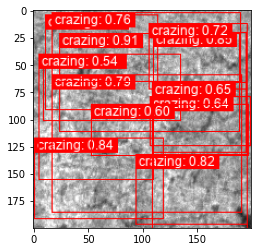

In [34]:
import time
i = 6

imgs, labels = next(iter(data_loader_test))
imgs = [img.to(device) for img in imgs]
fasterrcnn_model.eval()
with torch.no_grad():
    model_time = time.time()
    preds = fasterrcnn_model(imgs)
    model_time = time.time() - model_time
    print('FPS:', 8/model_time)
    preds = [{k: v.cpu() for k, v in t.items()} for t in preds]

img = imgs[i].permute(1, 2, 0).mul(255).byte().cpu().numpy()
pred = preds[i]

annotations = []
for (xmin, ymin, xmax, ymax), score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
    if score > 0.5:     # change this to see effect
        annotations.append([
                            (xmin + xmax) / 2 / img.shape[0],
                            (ymin + ymax) / 2 / img.shape[1],
                            (xmax - xmin) / img.shape[0],
                            (ymax - ymin) / img.shape[1],
                            score,
                            label - 1
        ])
plot_bbox(img, np.array(annotations))

https://remo.ai/docs/tutorial_pytorch_object_detection/

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

https://pytorch.org/vision/stable/ops.html

https://giou.stanford.edu/

//TODO:

đưa tất cả (true & pred) bboxes có IoU cao của 1 ảnh crazing, roll-in scale về một cái bbox duy nhất, rồi train lại xem có tốt hơn không?

faster rcnn: augmentation (mixcut, mosaic), auto anchor thật

tìm hiểu công nghệ mới trong yolov4, v5

thử dùng mô hình no-anchor: CornerNet, CenterNet

viet lai ham theo format: DRAW_BOUNDING_BOXES

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://blog.roboflow.com/yolov4-data-augmentation/

https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9

https://medium.com/@andersasac/the-end-of-anchors-improving-object-detection-models-and-annotations-73828c7b39f6

https://github.com/joydeepmedhi/Anchor-Boxes-with-KMeans

https://nerophung.github.io/2020/05/28/genetic-algorithm